# Ross Sea synthetic gravity inversion

Here we try to recover the true bathymetry with a gravity inversion for a portion of the Ross Sea. We create a synthetic gravity dataset which is the forward gravity of 3 density contrasts across real topographic surfaces. The first is the air-water surface, from BedMap2. The second is the water-sediment (bathymetry) surface, also from BedMap2. The third is the sediment-basement, from the ANTOSTRAT seismic surveys. We use three version of this synthetic observed gravity; 1) a "perfect" gravity survey at a constant 1000m above sea level, which stations evenly spacing in a 2km grid over the region, with and without 2% gaussian noise added, 2) a resampled gravity survey at 10km spacing, with and with 2% noise, and 3) a synthetic airborne survey, with N-S and E-W flight lines at a constant 1000m altitude, with several gaps between lines. We create a low-resolution bathymetry by samping the true bathymetry at 110 random "constraint" points, and regridding the surface with just these values. In an Antarctic setting, these points represent single seismic survey locations which image the bathymetry surface.

All of these processes are included in the notebook `Ross_Sea_synthetic_model.ipynb`.  While not included as a layer in the inversion, the forward gravity of the basement is included in the observed gravity. This field represents the regional gravity signal from factors such as long wavelength crustal thickness variations. 

import packages

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext snakeviz

import sys

sys.path.insert(1, "../")

import RIS_gravity_inversion.inversion as inv
import RIS_gravity_inversion.plotting as plots
import RIS_gravity_inversion.utils as inv_utils
import RIS_gravity_inversion.synthetic as synth 
import RIS_gravity_inversion.optimization as opti 

from antarctic_plots import utils, regions, maps, fetch, profile
import zarr
import harmonica as hm
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import verde as vd
import scipy as sp
import pvxarray
import rioxarray
import pygmt
import plotly.graph_objects as go
import optuna
from optuna.storages import JournalStorage, JournalFileStorage
import warnings

import os

# Load data

## topographic layers
* 3 full resolution synthetic layers
* low resolution layer 2

In [2]:
surface = xr.open_zarr("../synthetic_data/Ross_Sea_surface.zarr").z

bed = xr.open_zarr("../synthetic_data/Ross_Sea_bed.zarr").z

basement = xr.open_zarr("../synthetic_data/Ross_Sea_basement.zarr").z

lowres_bed = xr.open_zarr("../synthetic_data/Ross_Sea_lowres_bed.zarr").z

print(utils.get_grid_info(lowres_bed))
lowres_bed

/home/tankerma/miniconda/envs/RIS_gravity_inversion/lib/python3.9/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


(1000.0, [-300000.0, 250000.0, -1900000.0, -1500000.0], -3867.71337891, -284.587615967, 'g')


<xarray.DataArray 'z' (y: 401, x: 551)>
dask.array<open_dataset-fe16a342f9f9edeefcd530ba592420dez, shape=(401, 551), dtype=float32, chunksize=(201, 276), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 -3e+05 -2.99e+05 -2.98e+05 ... 2.49e+05 2.5e+05
  * y        (y) float64 -1.9e+06 -1.899e+06 -1.898e+06 ... -1.501e+06 -1.5e+06
Attributes:
    actual_range:  [-3867.71337890625, -284.5876159667969]
    long_name:     z

## gravity data
* full resolution gravity data
* 10km resampled gravity data
* airborne survey gravity data

* full resolution forward gravity of the regional field (basement)

In [3]:
# full resolution gravity grid
full_grav_grid = xr.open_zarr("../synthetic_data/Ross_Sea_forward_grav.zarr")

# true regional gravity anomaly
true_regional_grav = full_grav_grid.basement

# full resolution gravity point data
full_res_grav = pd.read_csv(
    "../synthetic_data/Ross_Sea_full_res_gravity.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)

# 10 km sampled gravity point data
sampled_grav = pd.read_csv(
    "../synthetic_data/Ross_Sea_sampled_gravity.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)

# airborne survey gravity point data
airborne_survey_grav = pd.read_csv(
    "../synthetic_data/Ross_Sea_airborne_survey_gravity.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)

# set standard column names
full_res_grav = full_res_grav.rename(columns={'free_air_anomaly':'Gobs'})
sampled_grav = sampled_grav.rename(columns={'free_air_anomaly':'Gobs'})
airborne_survey_grav = airborne_survey_grav.rename(columns={'free_air_anomaly':'Gobs'})

full_res_grav = full_res_grav.rename(columns={'ellipsoidal_elevation':'z'})
sampled_grav = sampled_grav.rename(columns={'ellipsoidal_elevation':'z'})
airborne_survey_grav = airborne_survey_grav.rename(columns={'ellipsoidal_elevation':'z'})

print(f"full resolution gravity: {len(full_res_grav)} points")
print(f"sampled  gravity: {len(sampled_grav)} points")
print(f"airborne survey gravity: {len(airborne_survey_grav)} points")

print(f"gravity avg. elevation: {int(np.nanmean(full_res_grav.z))}")

full resolution gravity: 2296 points
sampled  gravity: 609 points
airborne survey gravity: 3360 points
gravity avg. elevation: 1000


# Set region and parameters

Use the same regions and parameters as `synthetic_model_simple_with_regional.ipynb`

In [4]:
spacing, inversion_region, _, _, registration = utils.get_grid_info(bed)

# set gravity observation parameters
grav_observation_height = 1000
full_res_grav_spacing = 10e3
sampled_grav_spacing = 20e3
airborne_grav_spacing = 5e3

buffer_region = utils.alter_region(
    inversion_region,
    # buffer=0,
)[1]

print(f"spacing: {full_res_grav_spacing}m")
print("registration: {registration}")
print("inversion region = ", inversion_region)
print("buffer region = ", buffer_region)

spacing: 10000.0m
registration: {registration}
inversion region =  [-300000.0, 250000.0, -1900000.0, -1500000.0]
buffer region =  [-300000, 250000, -1900000, -1500000]


## constraint points

In [5]:
# load constraint points into a dataframe
constraint_points_all = pd.read_csv(
    "../synthetic_data/Ross_Sea_synthetic_constraints.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)

# ensure all points are within inversion region
constraint_points = utils.points_inside_region(
    constraint_points_all,
    inversion_region,
)

print(f"bathymetry control points:{len(constraint_points)}")
constraint_points.head()

bathymetry control points:110


x             y            z
0  -60202.803822 -1.794489e+06  -672.470024
1 -285740.572495 -1.534434e+06 -1704.880401
2    2314.362833 -1.732106e+06  -288.343065
3  -60572.684060 -1.683923e+06  -472.233651
4  -68797.708852 -1.656623e+06  -477.404576

## plot inputs

returning original grid


grd2cpt [ERROR]: Making a continuous cpt from a discrete cpt may give unexpected results!


returning original grid


grd2cpt [ERROR]: Making a continuous cpt from a discrete cpt may give unexpected results!


returning original grid


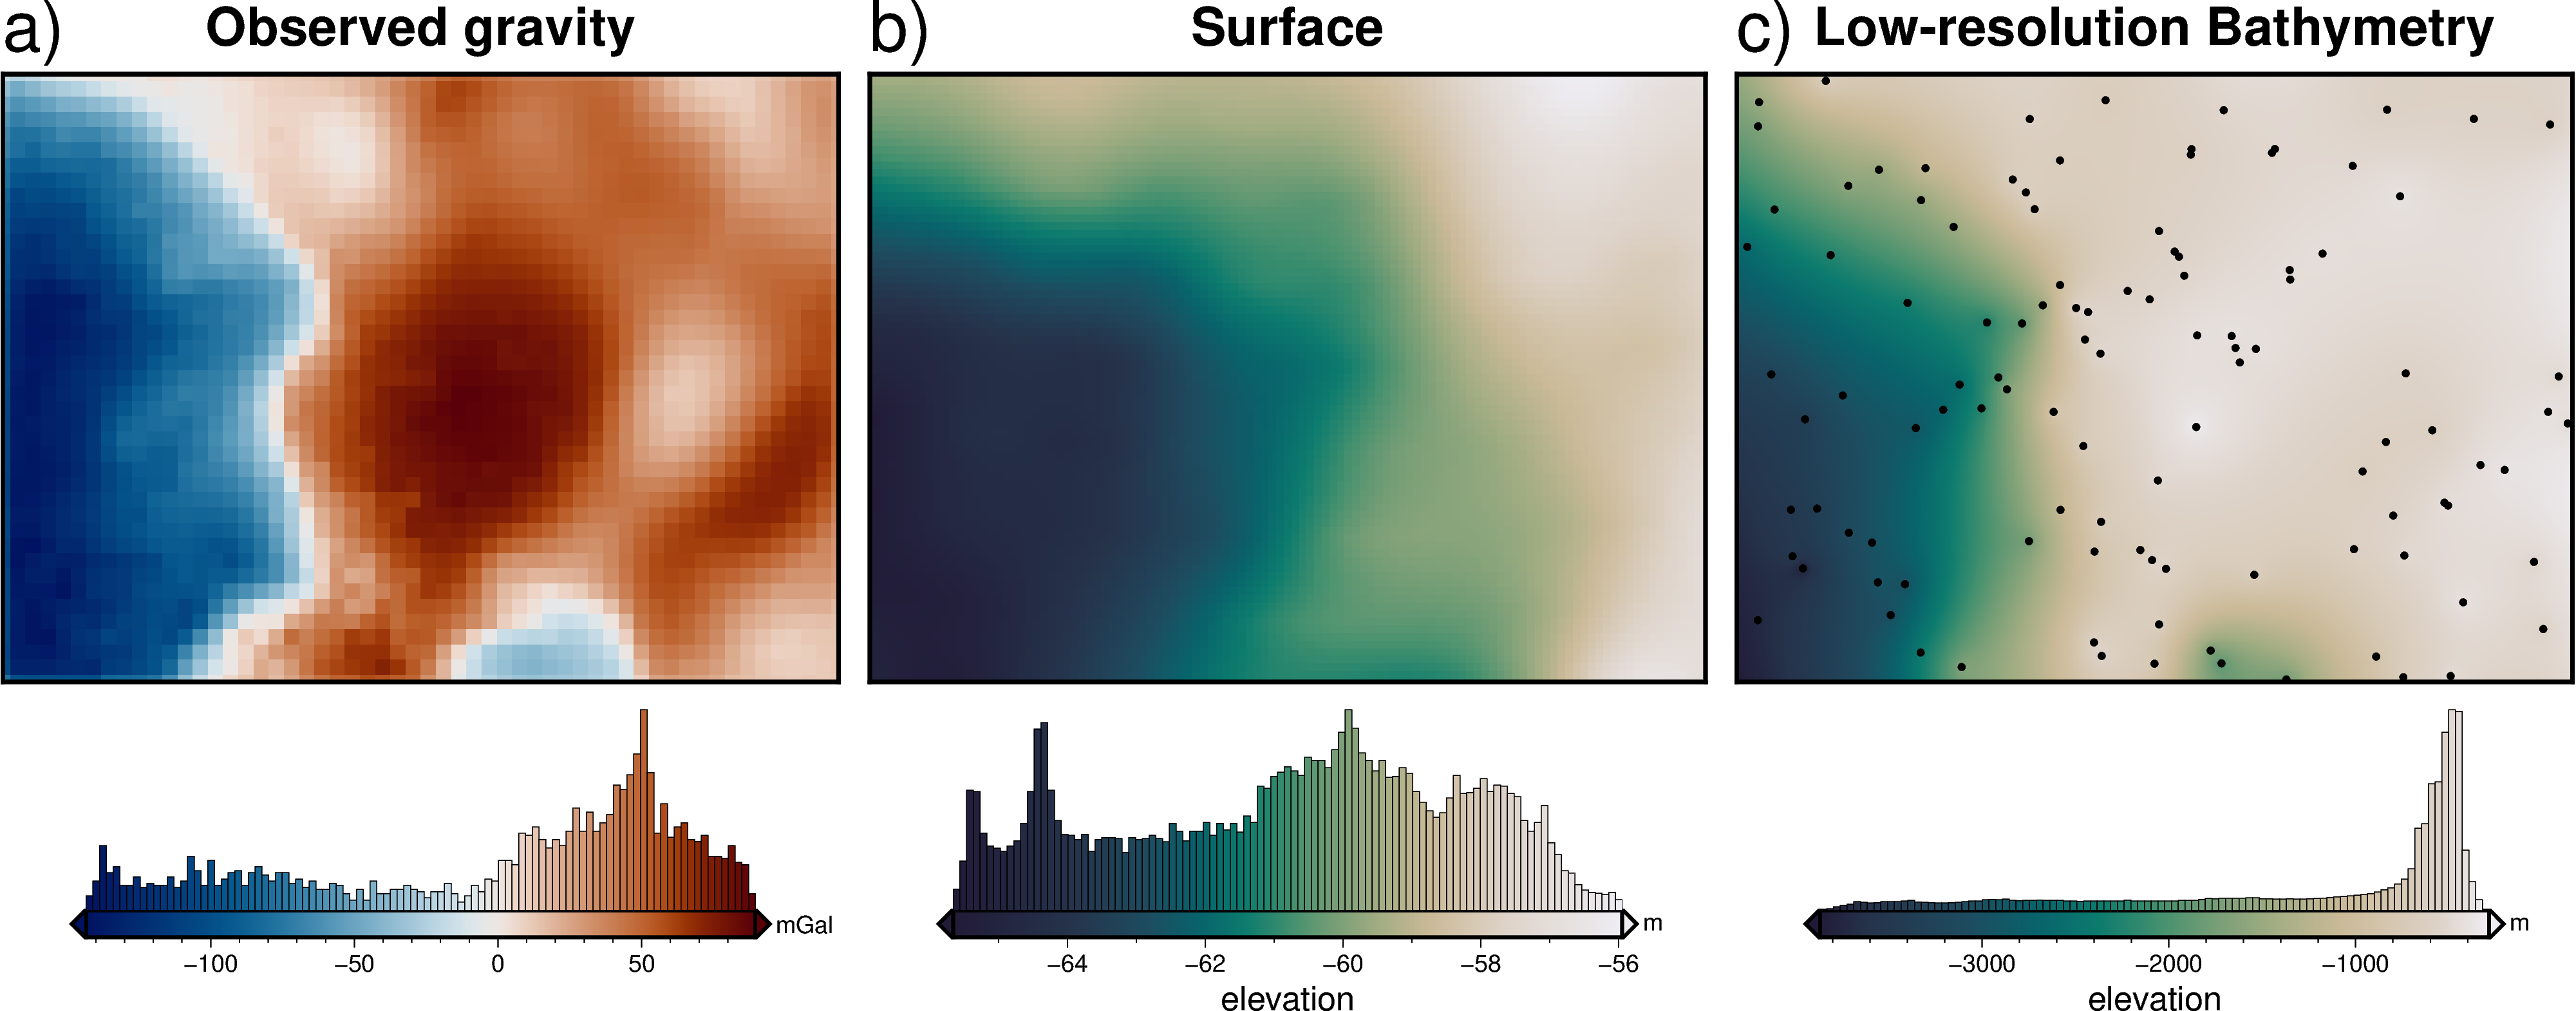

In [6]:
# grid the observed gravity
Gobs = full_res_grav.set_index(["y", "x"]).to_xarray().Gobs

# plot observed gravity
fig = maps.plot_grd(
    grid=Gobs,
    fig_height=8,
    cmap="vik+h0",
    region=buffer_region,
    title="Observed gravity",
    cbar_unit="mGal",
    show_region=inversion_region,
    hist=True,
    cbar_yoffset=3,
)
fig.text(
    position='TL',
    justify='BL',
    text = "a)",
    font = '26p,Helvetica,black',
    offset = 'j0/.3',
    no_clip=True,
)

# plot layer 1
fig = maps.plot_grd(
    grid=surface,
    fig_height=8,
    cmap="rain",
    reverse_cpt=True,
    region=buffer_region,
    grd2cpt=True,
    title="Surface",
    cbar_label="elevation",
    cbar_unit="m",
    show_region=inversion_region,
    hist=True,
    cbar_yoffset=3,
    fig=fig,
    origin_shift="xshift",
)
fig.text(
    position='TL',
    justify='BL',
    text = "b)",
    font = '26p,Helvetica,black',
    offset = 'j0/.3',
    no_clip=True,
)

# plot layer 2
fig = maps.plot_grd(
    grid=lowres_bed,
    fig_height=8,
    cmap="rain",
    reverse_cpt=True,
    region=buffer_region,
    grd2cpt=True,
    title="Low-resolution Bathymetry",
    cbar_label="elevation",
    cbar_unit="m",
    show_region=inversion_region,
    hist=True,
    cbar_yoffset=3,
    fig=fig,
    origin_shift="xshift",
    points=constraint_points,
    points_style="c0.1c",
)
fig.text(
    position='TL',
    justify='BL',
    text = "c)",
    font = '26p,Helvetica,black',
    offset = 'j0/.3',
    no_clip=True,
)

fig.show()

# Bouguer correction

The `observed gravity` includes a gravitational signal from density contrast of the water surface, the bathymetry, and the basement. Since we want to invert for the bathymetry, we need to remove the components of this gravity from the water surface and the regional field from the basement. Here we show how to remove the water surface component, and later will show how to remove the regional component.

To do this, we build a series of vertical prisms around a flat reference, which we take to be the mean value of the surface. The prisms extend above or below this reference, towards the water surface. Prisms above the reference are assigned a positive density contrast ($\rho_{water}$ - $\rho_{air}$), while prisms below the reference are assigned a negative density contrast ($\rho_{air}$ - $\rho_{water}$). This is shown in b) and c) of the below figure.

At each stage of the inversion, the we ensure the updated bathymetry doesn't intersect the water surface. This means the water surface density contrast will be constant throughout the inversion, and can thus be calculated and accounted for only once, at the beginning. 

Here, we calculate the forward gravity of this density contrast, and remove it from the observed gravity to make a `corrected observed gravity`. 

<img src="../figures/synthetic_model_simple_2layer.svg" width="1000"/>

## Water prisms

In [6]:
# create prisms around Layer 1
# positive densities above reference, negative below
water_prisms = inv_utils.grids_to_prisms(
    top=surface,
    bottom=surface.values.mean(),
    density=xr.where(surface>=surface.values.mean(), 1030, -1030),
)

# plots.show_prism_layers(
#     [water_prisms],
#     cmap="viridis",
#     color_by="density",
#     # color_by="thickness",
#     zscale=100,
#     clip_box=False,
#     log_scale=False,
# )

## Water gravity

In [8]:
# calculate gravity of layer1
water_grav_grid, water_grav_df = inv_utils.forward_grav_of_prismlayer(
    [water_prisms],
    full_res_grav,
    names=['water_prisms'],
    remove_median=True,
    progressbar=True,
    plot=False,
)

full_res_grav['water_forward'] = water_grav_df.forward_total

# subtract from observed gravity
full_res_grav['Gobs_corr']=full_res_grav.Gobs - full_res_grav.water_forward

# center on 0
full_res_grav['Gobs_corr'] -= full_res_grav['Gobs_corr'].median()

# grid the results
water_forward = full_res_grav.set_index(["y", "x"]).to_xarray().water_forward
Gobs_corr = full_res_grav.set_index(["y", "x"]).to_xarray().Gobs_corr

# center on 0
water_forward -= np.median(water_forward)
Gobs_corr -= np.median(Gobs_corr)
full_res_grav

  0%|          | 0/2296 [00:00<?, ?it/s]

x          y  lat  lon  station_ID       z  geoidal_elevation  \
0    -300000.0 -1900000.0  NaN  NaN         NaN  1000.0                NaN   
1    -290000.0 -1900000.0  NaN  NaN         NaN  1000.0                NaN   
2    -280000.0 -1900000.0  NaN  NaN         NaN  1000.0                NaN   
3    -270000.0 -1900000.0  NaN  NaN         NaN  1000.0                NaN   
4    -260000.0 -1900000.0  NaN  NaN         NaN  1000.0                NaN   
...        ...        ...  ...  ...         ...     ...                ...   
2291  210000.0 -1500000.0  NaN  NaN         NaN  1000.0                NaN   
2292  220000.0 -1500000.0  NaN  NaN         NaN  1000.0                NaN   
2293  230000.0 -1500000.0  NaN  NaN         NaN  1000.0                NaN   
2294  240000.0 -1500000.0  NaN  NaN         NaN  1000.0                NaN   
2295  250000.0 -1500000.0  NaN  NaN         NaN  1000.0                NaN   

      elevation_error  observed_gravity  observed_gravity_error  \
0                 NaN               NaN                     NaN   
1                 NaN               NaN                     NaN   
2                 NaN               NaN                     NaN   
3                 NaN               NaN                     NaN   
4                 NaN               NaN                     NaN   
...               ...               ...                     ...   
2291              NaN               NaN                     NaN   
2292              NaN               NaN                     NaN   
2293              NaN               NaN                     NaN   
2294              NaN               NaN                     NaN   
2295              NaN               NaN                     NaN   

      gravity_disturbance  gravity_disturbance_error        Gobs  \
0                     NaN                        NaN  -78.276366   
1                     NaN                        NaN  -99.638928   
2                     NaN                        NaN -101.205229   
3                     NaN                        NaN -101.049857   
4                     NaN                        NaN  -99.767248   
...                   ...                        ...         ...   
2291                  NaN                        NaN   16.948870   
2292                  NaN                        NaN   20.663266   
2293                  NaN                        NaN   24.627830   
2294                  NaN                        NaN   26.360442   
2295                  NaN                        NaN   22.872381   

      free_air_anomaly_error  water_forward   Gobs_corr  
0                        NaN      -0.162231 -104.236906  
1                        NaN      -0.179547 -125.582153  
2                        NaN      -0.184198 -127.143803  
3                        NaN      -0.188003 -126.984626  
4                        NaN      -0.189793 -125.700227  
...                      ...            ...         ...  
2291                     NaN       0.143958   -9.317860  
2292                     NaN       0.138050   -5.597556  
2293                     NaN       0.133196   -1.628137  
2294                     NaN       0.129832    0.107838  
2295                     NaN       0.117214   -3.367605  

[2296 rows x 16 columns]

returning original grid
returning original grid


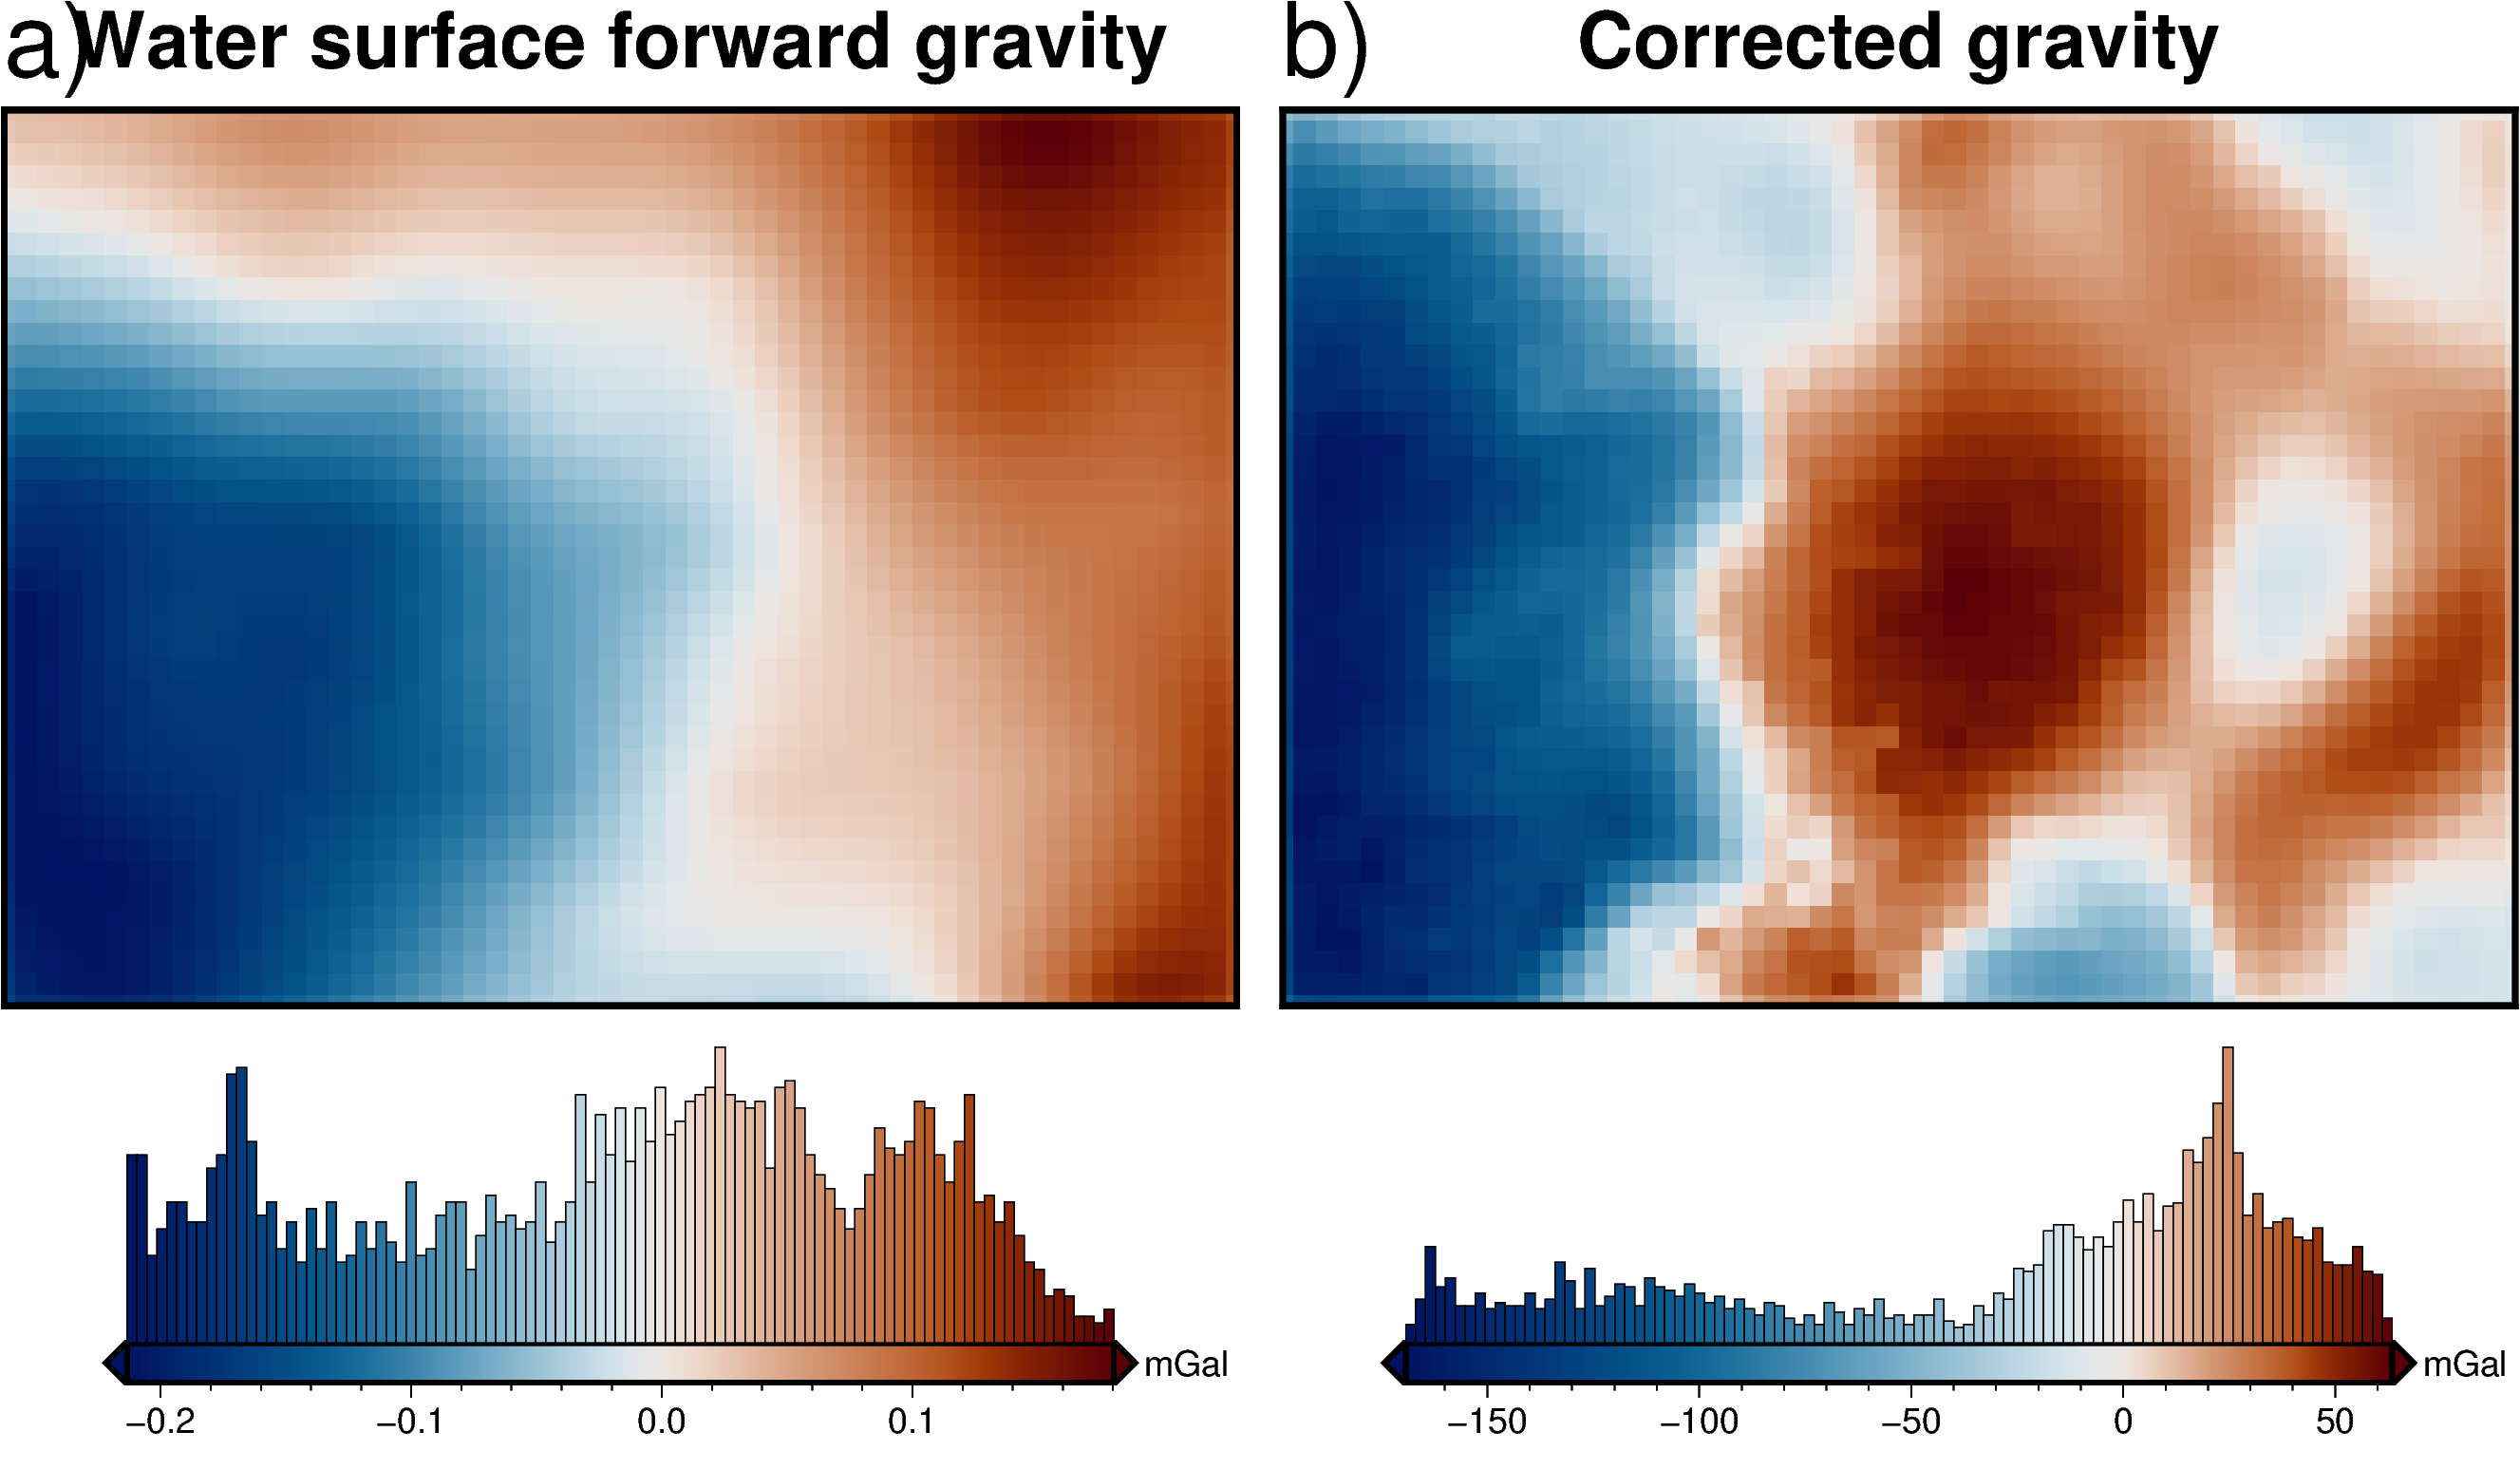

In [9]:
# plot Layer 1 gravity
fig = maps.plot_grd(
    grid=water_forward,
    fig_height=8,
    cmap="vik+h0",
    region=buffer_region,
    title='Water surface forward gravity',
    cbar_unit="mGal",
    show_region=inversion_region,
    hist=True,
    cbar_yoffset=3,
)
fig.text(
    position='TL',
    justify='BL',
    text = "a)",
    font = '26p,Helvetica,black',
    offset = 'j0/.3',
    no_clip=True,
)
# plot corrected gravity
fig = maps.plot_grd(
    grid=Gobs_corr,
    fig_height=8,
    cmap="vik+h0",
    region=buffer_region,
    title="Corrected gravity",
    cbar_unit="mGal",
    show_region=inversion_region,
    hist=True,
    cbar_yoffset=3,
    fig=fig,
    origin_shift="xshift",
)
fig.text(
    position='TL',
    justify='BL',
    text = "b)",
    font = '26p,Helvetica,black',
    offset = 'j0/.3',
    no_clip=True,
)
fig.show()

# Gravity misfit

The `gravity misfit` is defined as the difference between the observed and predicted gravity:

$G_{misfit} = G_{obs} - G_{forward}$ 

To determine $G_{misfit}$, we need to forward model the gravitational effect of the low-resolution bathymetry density contrast. This will be the input into our inversion.


## Bed prisms

In [7]:
# create prisms around low-res bathymetry
# positive densities above reference, negative below
bed_prisms = inv_utils.grids_to_prisms(
    top=lowres_bed,
    bottom=lowres_bed.values.mean(),
    density=xr.where(lowres_bed>=lowres_bed.values.mean(), 2300-1030, -(2300-1030)),
)

# plots.show_prism_layers(
#     [layer2_prisms],
#     cmap="viridis",
#     color_by="density",
#     # color_by="thickness",
#     zscale=100,
#     clip_box=False,
#     log_scale=False,
# )

## bed gravity

In [11]:
# calculate gravity of layer1
bed_grav_grid, bed_grav_df = inv_utils.forward_grav_of_prismlayer(
    [bed_prisms],
    full_res_grav,
    names=['bed_prisms'],
    remove_median=True,
    progressbar=True,
    plot=False,
)

full_res_grav['bed_forward'] = bed_grav_df.forward_total

# grid the results
bed_forward = full_res_grav.set_index(["y", "x"]).to_xarray().bed_forward

# center on 0
bed_forward -= np.median(bed_forward)

full_res_grav

  0%|          | 0/2296 [00:00<?, ?it/s]

x          y  lat  lon  station_ID       z  geoidal_elevation  \
0    -300000.0 -1900000.0  NaN  NaN         NaN  1000.0                NaN   
1    -290000.0 -1900000.0  NaN  NaN         NaN  1000.0                NaN   
2    -280000.0 -1900000.0  NaN  NaN         NaN  1000.0                NaN   
3    -270000.0 -1900000.0  NaN  NaN         NaN  1000.0                NaN   
4    -260000.0 -1900000.0  NaN  NaN         NaN  1000.0                NaN   
...        ...        ...  ...  ...         ...     ...                ...   
2291  210000.0 -1500000.0  NaN  NaN         NaN  1000.0                NaN   
2292  220000.0 -1500000.0  NaN  NaN         NaN  1000.0                NaN   
2293  230000.0 -1500000.0  NaN  NaN         NaN  1000.0                NaN   
2294  240000.0 -1500000.0  NaN  NaN         NaN  1000.0                NaN   
2295  250000.0 -1500000.0  NaN  NaN         NaN  1000.0                NaN   

      elevation_error  observed_gravity  observed_gravity_error  \
0                 NaN               NaN                     NaN   
1                 NaN               NaN                     NaN   
2                 NaN               NaN                     NaN   
3                 NaN               NaN                     NaN   
4                 NaN               NaN                     NaN   
...               ...               ...                     ...   
2291              NaN               NaN                     NaN   
2292              NaN               NaN                     NaN   
2293              NaN               NaN                     NaN   
2294              NaN               NaN                     NaN   
2295              NaN               NaN                     NaN   

      gravity_disturbance  gravity_disturbance_error        Gobs  \
0                     NaN                        NaN  -78.276366   
1                     NaN                        NaN  -99.638928   
2                     NaN                        NaN -101.205229   
3                     NaN                        NaN -101.049857   
4                     NaN                        NaN  -99.767248   
...                   ...                        ...         ...   
2291                  NaN                        NaN   16.948870   
2292                  NaN                        NaN   20.663266   
2293                  NaN                        NaN   24.627830   
2294                  NaN                        NaN   26.360442   
2295                  NaN                        NaN   22.872381   

      free_air_anomaly_error  water_forward   Gobs_corr  bed_forward  
0                        NaN      -0.162231 -104.236906   -66.614896  
1                        NaN      -0.179547 -125.582153   -92.621181  
2                        NaN      -0.184198 -127.143803   -94.358154  
3                        NaN      -0.188003 -126.984626   -93.566010  
4                        NaN      -0.189793 -125.700227   -91.910381  
...                      ...            ...         ...          ...  
2291                     NaN       0.143958   -9.317860    -6.416209  
2292                     NaN       0.138050   -5.597556    -6.401394  
2293                     NaN       0.133196   -1.628137    -6.280093  
2294                     NaN       0.129832    0.107838    -6.214447  
2295                     NaN       0.117214   -3.367605   -13.217940  

[2296 rows x 17 columns]

## Save and load results

In [12]:
full_res_grav.to_csv(
    "../synthetic_data/Ross_Sea_full_res_forward_gravity.csv.gz",
    sep=",",
    na_rep="",
    header=True,
    index=False,
    encoding="utf-8",
    compression="gzip",
) 

In [8]:
full_res_grav = pd.read_csv(
    "../synthetic_data/Ross_Sea_full_res_forward_gravity.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)

full_res_grav

x          y  lat  lon  station_ID       z  geoidal_elevation  \
0    -300000.0 -1900000.0  NaN  NaN         NaN  1000.0                NaN   
1    -290000.0 -1900000.0  NaN  NaN         NaN  1000.0                NaN   
2    -280000.0 -1900000.0  NaN  NaN         NaN  1000.0                NaN   
3    -270000.0 -1900000.0  NaN  NaN         NaN  1000.0                NaN   
4    -260000.0 -1900000.0  NaN  NaN         NaN  1000.0                NaN   
...        ...        ...  ...  ...         ...     ...                ...   
2291  210000.0 -1500000.0  NaN  NaN         NaN  1000.0                NaN   
2292  220000.0 -1500000.0  NaN  NaN         NaN  1000.0                NaN   
2293  230000.0 -1500000.0  NaN  NaN         NaN  1000.0                NaN   
2294  240000.0 -1500000.0  NaN  NaN         NaN  1000.0                NaN   
2295  250000.0 -1500000.0  NaN  NaN         NaN  1000.0                NaN   

      elevation_error  observed_gravity  observed_gravity_error  \
0                 NaN               NaN                     NaN   
1                 NaN               NaN                     NaN   
2                 NaN               NaN                     NaN   
3                 NaN               NaN                     NaN   
4                 NaN               NaN                     NaN   
...               ...               ...                     ...   
2291              NaN               NaN                     NaN   
2292              NaN               NaN                     NaN   
2293              NaN               NaN                     NaN   
2294              NaN               NaN                     NaN   
2295              NaN               NaN                     NaN   

      gravity_disturbance  gravity_disturbance_error        Gobs  \
0                     NaN                        NaN  -78.276366   
1                     NaN                        NaN  -99.638928   
2                     NaN                        NaN -101.205229   
3                     NaN                        NaN -101.049857   
4                     NaN                        NaN  -99.767248   
...                   ...                        ...         ...   
2291                  NaN                        NaN   16.948870   
2292                  NaN                        NaN   20.663266   
2293                  NaN                        NaN   24.627830   
2294                  NaN                        NaN   26.360442   
2295                  NaN                        NaN   22.872381   

      free_air_anomaly_error  water_forward   Gobs_corr  bed_forward  
0                        NaN      -0.162231 -104.236906   -66.614896  
1                        NaN      -0.179547 -125.582153   -92.621181  
2                        NaN      -0.184198 -127.143803   -94.358154  
3                        NaN      -0.188003 -126.984626   -93.566010  
4                        NaN      -0.189793 -125.700227   -91.910381  
...                      ...            ...         ...          ...  
2291                     NaN       0.143958   -9.317860    -6.416209  
2292                     NaN       0.138050   -5.597556    -6.401394  
2293                     NaN       0.133196   -1.628137    -6.280093  
2294                     NaN       0.129832    0.107838    -6.214447  
2295                     NaN       0.117214   -3.367605   -13.217940  

[2296 rows x 17 columns]

returning original grid


grd2cpt [ERROR]: Making a continuous cpt from a discrete cpt may give unexpected results!


returning original grid


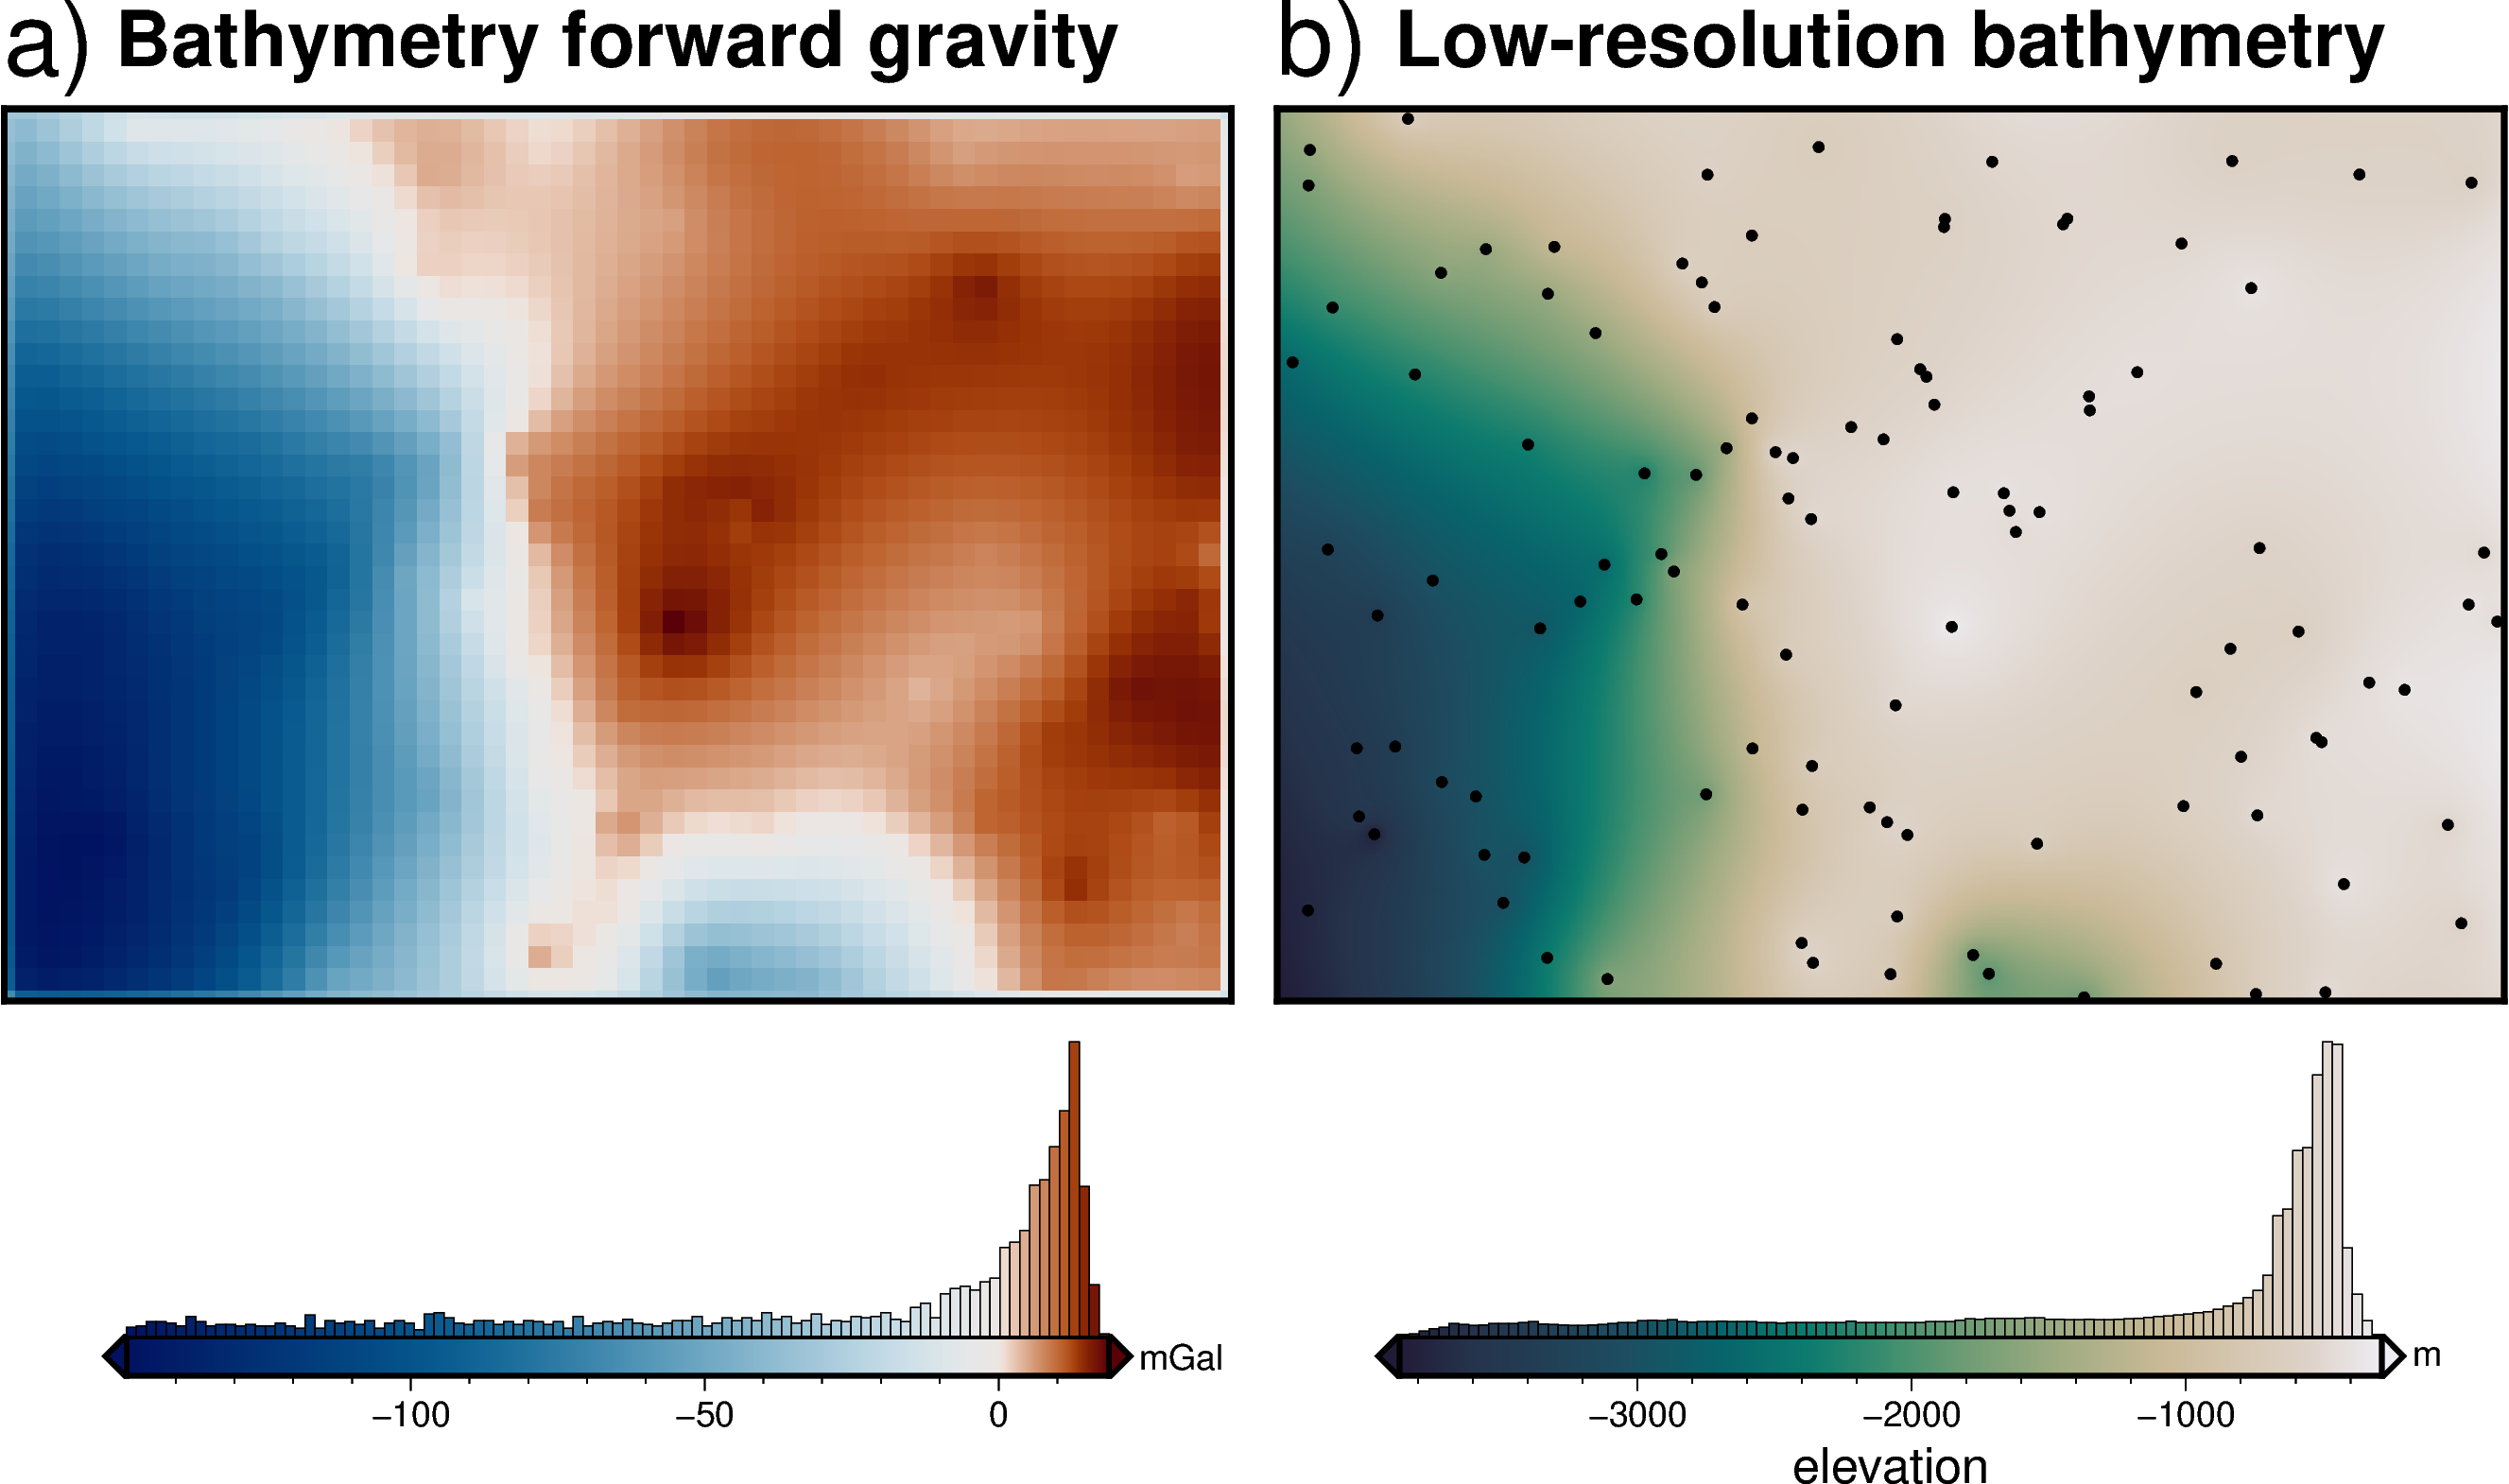

In [14]:
# plot layer 2 gravity
fig = maps.plot_grd(
    grid=bed_forward,
    fig_height=8,
    cmap="vik+h0",
    region=buffer_region,
    title="Bathymetry forward gravity",
    cbar_unit="mGal",
    show_region=inversion_region,
    hist=True,
    cbar_yoffset=3,
)
fig.text(
    position='TL',
    justify='BL',
    text = "a)",
    font = '26p,Helvetica,black',
    offset = 'j0/.3',
    no_clip=True,
)
# plot layer 2 topography
fig = maps.plot_grd(
    grid=lowres_bed,
    fig_height=8,
    cmap="rain",
    reverse_cpt=True,
    region=buffer_region,
    grd2cpt=True,
    title="Low-resolution bathymetry",
    cbar_label="elevation",
    cbar_unit="m",
    show_region=inversion_region,
    hist=True,
    cbar_yoffset=3,
    fig=fig,
    origin_shift="xshift",
    points=constraint_points,
    points_style="c0.1c",
)
fig.text(
    position='TL',
    justify='BL',
    text = "b)",
    font = '26p,Helvetica,black',
    offset = 'j0/.3',
    no_clip=True,
)
fig.show()

## Regional - Residual seperation

The `corrected observed gravity` is the combination of the signal from the density contrasts of `bathymetry` and `basement`. Both of these signals contain long-wavelength components, since both surface have long-wavelength topographic features. The `bathymetry` signal also contains short-wavelength components. Deeper in the crust, further away from the gravity observation points, these short-wavelength components decrease in amplitude. This means the majority the short-wavelength signal in the `corrected observed gravity` is resulting from the density contrast of the `bathymetry`. This is the signal we want to isolate and input into the inversion. 

To do this, we need to seperate the gravity misfit into a `regional` component and a `residual` component. This `regional` field should theoretically contain every gravity signal other than the that resulting from the `bathymetry` surface. Additionaly, this `residual` component should theoretically represent the gravity anomaly due to the difference between the true `bathymetry` and the low-resolution `bathymetry`. 

If we fail to accurately remove the `regional` signal, the resulting `bathymetry` after the inversion will contain long-wavelength topography, resulting from the `regional` gravity field. 

Since we created the synthetic model, we precisely know the regional component (the forward gravity of the `basement`), and can thus tune our regional-residual seperation method to accurately remove the regional field. 

### optimize the regional-residual seperation

We have 4 methods to seperate the regional misfit from the residual misfit.
1) `Filter` method: Apply a low-pass filter to the misfit
2) `Trend` method: Fit a trend to the misfit
3) `Constraints` method: Sample and grid the misfit only at constraint points, where we know the true layer depth
4) `Equivalent-Sources` method: Predict the gravity anomaly resulting from a serious of deep sources.

Each of these methods has 1 parameter to tune. Respectively, these are 
1) gaussian low-pass filter width (1km - 1000km)
2) trend order (1 - 20)
3) gridding tension factor (0 - 1)
4) source depth (10km - 10,000km)

The optimization will explore the parameter space of each of these, and return the parameters which result in your choice of:
a) a `regional misfit` closest to the true layer 3 forward gravity,
b) the smallest `residuals` at the constraint points

Since we know the true `regional` field, we will use method a). For a true inversion where you don't know the `regional` field, you can use method b). This method finds the seperation method which minimize the `residuals` at contraint points. Since at these contraint points you know the starting layer elevation is accurate, the misfit should be entirely due to the `regional` field, and the `residual` should be close to 0. 

Choose to either run all 4 methods in the same optimization, or run each seperately. 

In [9]:
regional_kwargs = dict(
    input_grav=full_res_grav,
    input_forward_column = 'bed_forward',
    input_grav_column = 'Gobs_corr',
    grav_spacing=full_res_grav_spacing,
    inversion_region=inversion_region,
    true_regional=true_regional_grav,
    constraints=constraint_points,
    block_size=full_res_grav_spacing*10,
)

## Optimize all methods individually

In [10]:
# set comparison method
# comparison_method='minimize_constraints'
comparison_method='regional_comparison'

methods = [
    "filter", 
    "trend", 
    "constraints", 
    "eq_sources"
    ]

# for i in methods:
#     # set name and storage for the optimization
#     study_name = f"Ross_Sea_regional_seperation_indiv_{i}_{comparison_method}"
#     storage = JournalStorage(JournalFileStorage(f"../optimization_logs/{study_name}.log"))

#     # set number of runs
#     n_trials=50

#     # create a new study
#     study = optuna.create_study(
#         study_name=study_name,
#         storage=storage,
#         direction="minimize",
#         # sampler=optuna.samplers.TPESampler(n_startup_trials=int(n_trials/3)),
#         sampler=optuna.integration.BoTorchSampler(n_startup_trials=int(n_trials/3)),
#         load_if_exists=True,
#         )

#     # define the objective function
#     objective = opti.optimal_regional_params(
#         comparison_method = comparison_method,
#         regional_method = i,
#         filter_limits = [10e3, 1000e3, 10e3], # 100 options
#         trend_limits = [1, 20, 1], # 20 options
#         constraints_limits = [0, 1, 0.01], # 101 options
#         eq_sources_limits = [10e3, 10000e3, 10e3], # 1000 options
#         **regional_kwargs)

#     # run the optimization
#     with inv_utils.HiddenPrints():
#         with warnings.catch_warnings():
#             warnings.simplefilter("ignore")
#             study, study_df = opti.optuna_parallel(
#                 study_name=study_name,
#                 study_storage=storage,
#                 objective=objective,
#                 n_trials=n_trials,
#                 maximize_cpus=True,
#             )

/tmp/ipykernel_2901138/3424513478.py:5: ExperimentalWarning: JournalStorage is experimental (supported from v3.1.0). The interface can change in the future.
  storage = JournalStorage(JournalFileStorage(f"../optimization_logs/{study_name}.log"))



########## filter ##########
number                                       47
value                                  3.725972
datetime_start       2023-03-01 16:18:43.113453
datetime_complete    2023-03-01 16:19:44.829238
duration                 0 days 00:01:01.715785
params_filter                            120000
state                                  COMPLETE
Name: 47, dtype: object
returning original grid
returning original grid


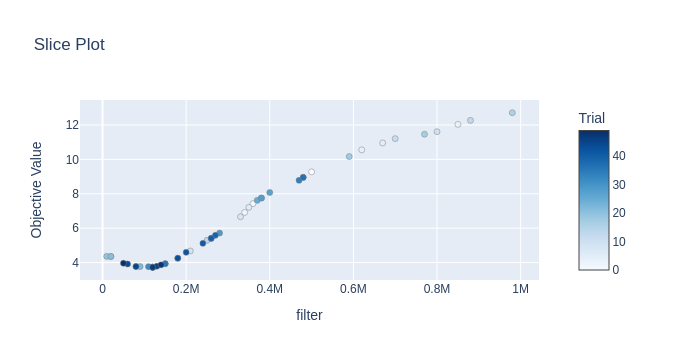

/tmp/ipykernel_2901138/3424513478.py:5: ExperimentalWarning:

JournalStorage is experimental (supported from v3.1.0). The interface can change in the future.




########## trend ##########
number                                       24
value                                  3.986918
datetime_start       2023-03-01 16:19:48.132132
datetime_complete    2023-03-01 16:20:18.949543
duration                 0 days 00:00:30.817411
params_trend                                 20
state                                  COMPLETE
Name: 24, dtype: object
returning original grid
returning original grid


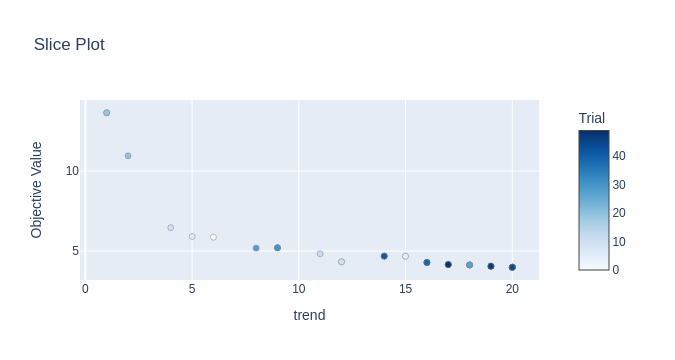

/tmp/ipykernel_2901138/3424513478.py:5: ExperimentalWarning:

JournalStorage is experimental (supported from v3.1.0). The interface can change in the future.




########## constraints ##########
number                                        17
value                                   3.095578
datetime_start        2023-03-01 16:20:50.996109
datetime_complete     2023-03-01 16:21:17.982372
duration                  0 days 00:00:26.986263
params_constraints                          0.28
state                                   COMPLETE
Name: 17, dtype: object
returning original grid
returning original grid


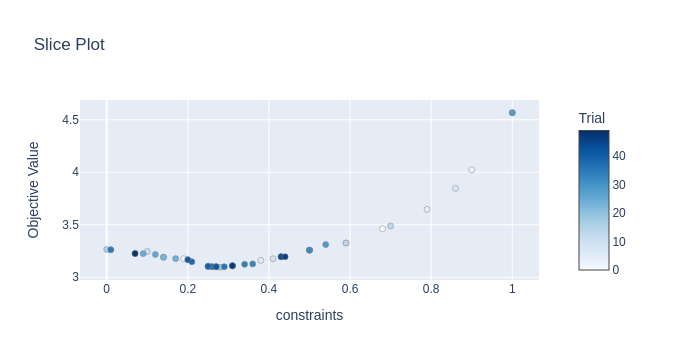

/tmp/ipykernel_2901138/3424513478.py:5: ExperimentalWarning:

JournalStorage is experimental (supported from v3.1.0). The interface can change in the future.




########## eq_sources ##########
number                                        3
value                                  5.576068
datetime_start       2023-03-01 16:22:07.119573
datetime_complete    2023-03-01 16:22:13.581053
duration                 0 days 00:00:06.461480
params_eq_sources                       3010000
state                                  COMPLETE
Name: 3, dtype: object
returning original grid
returning original grid


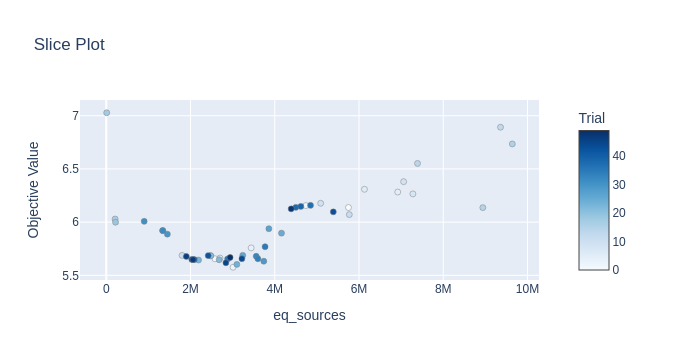

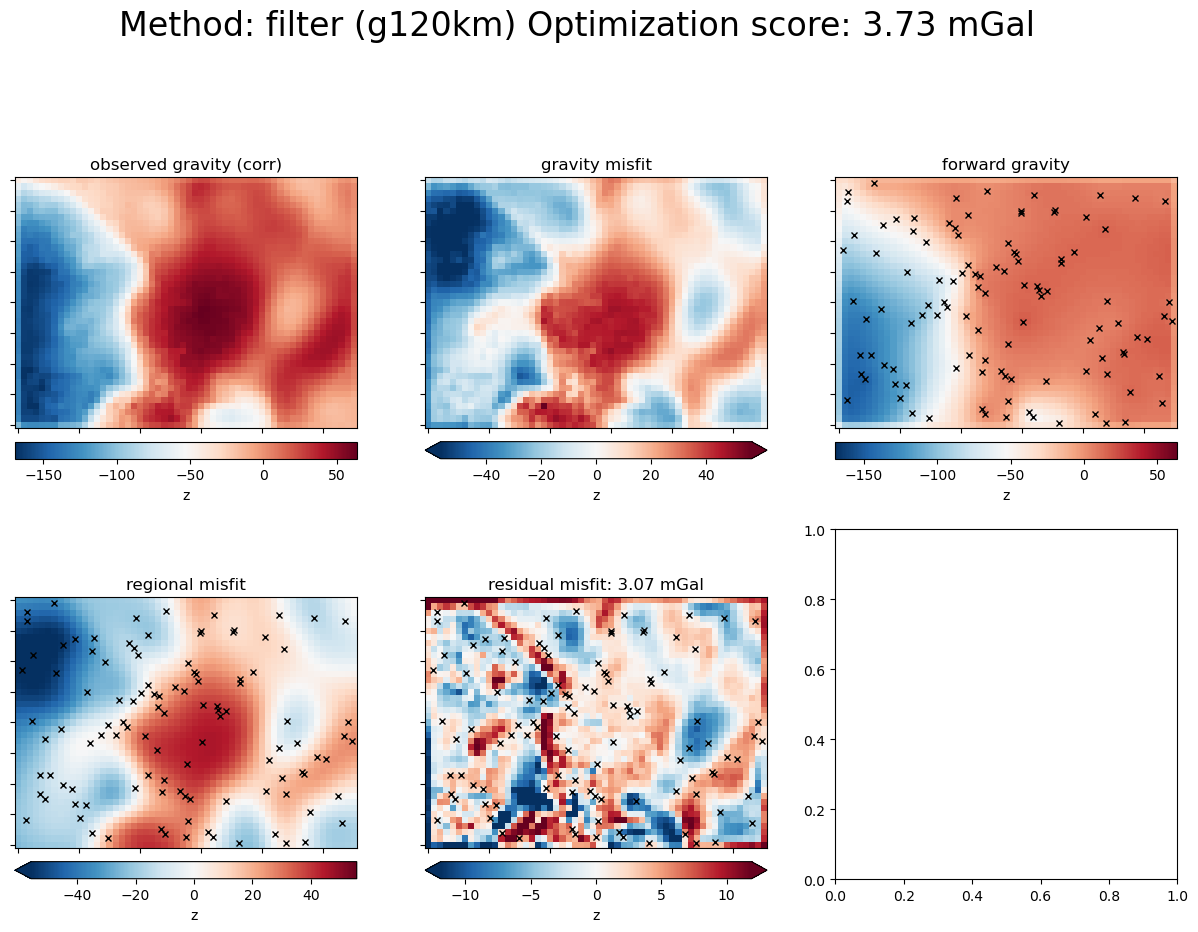

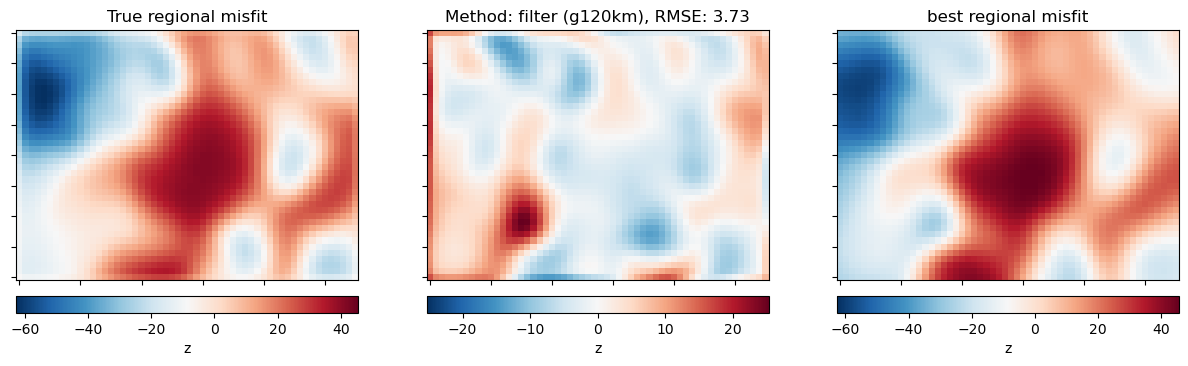

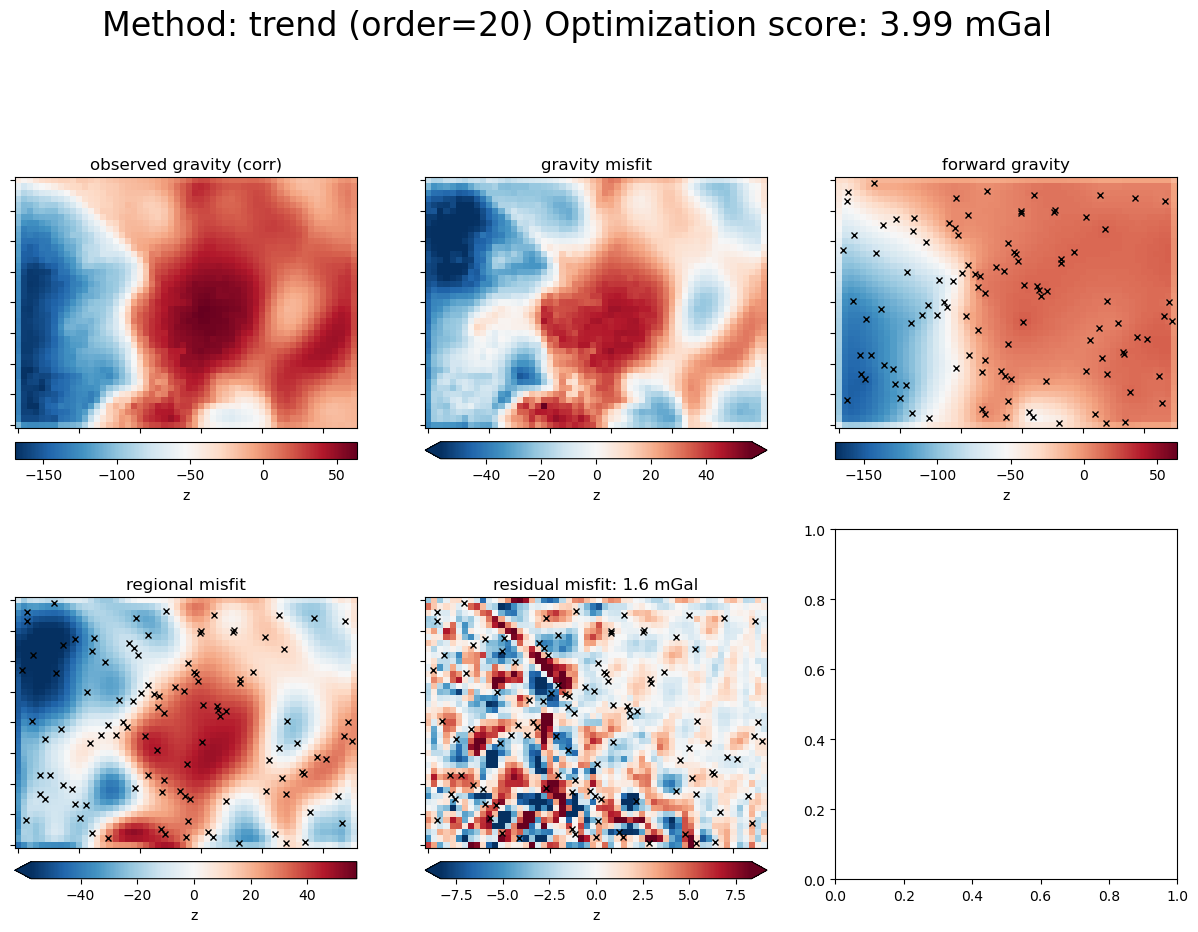

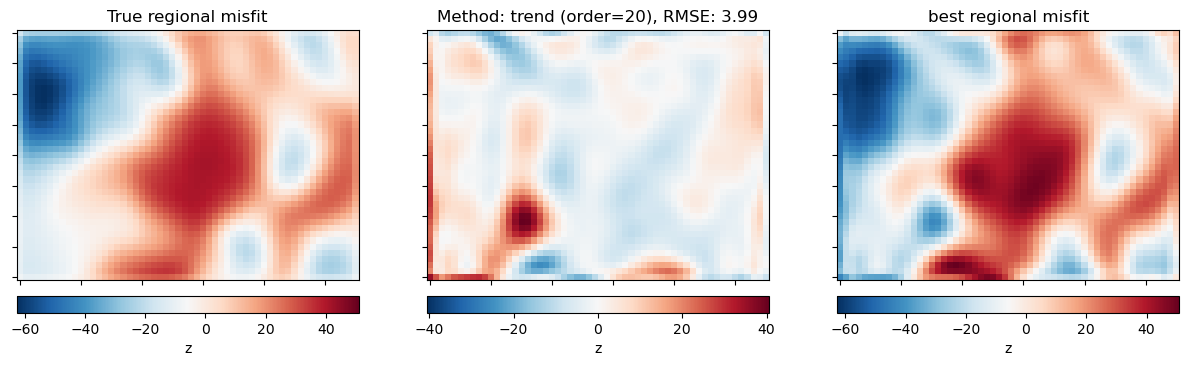

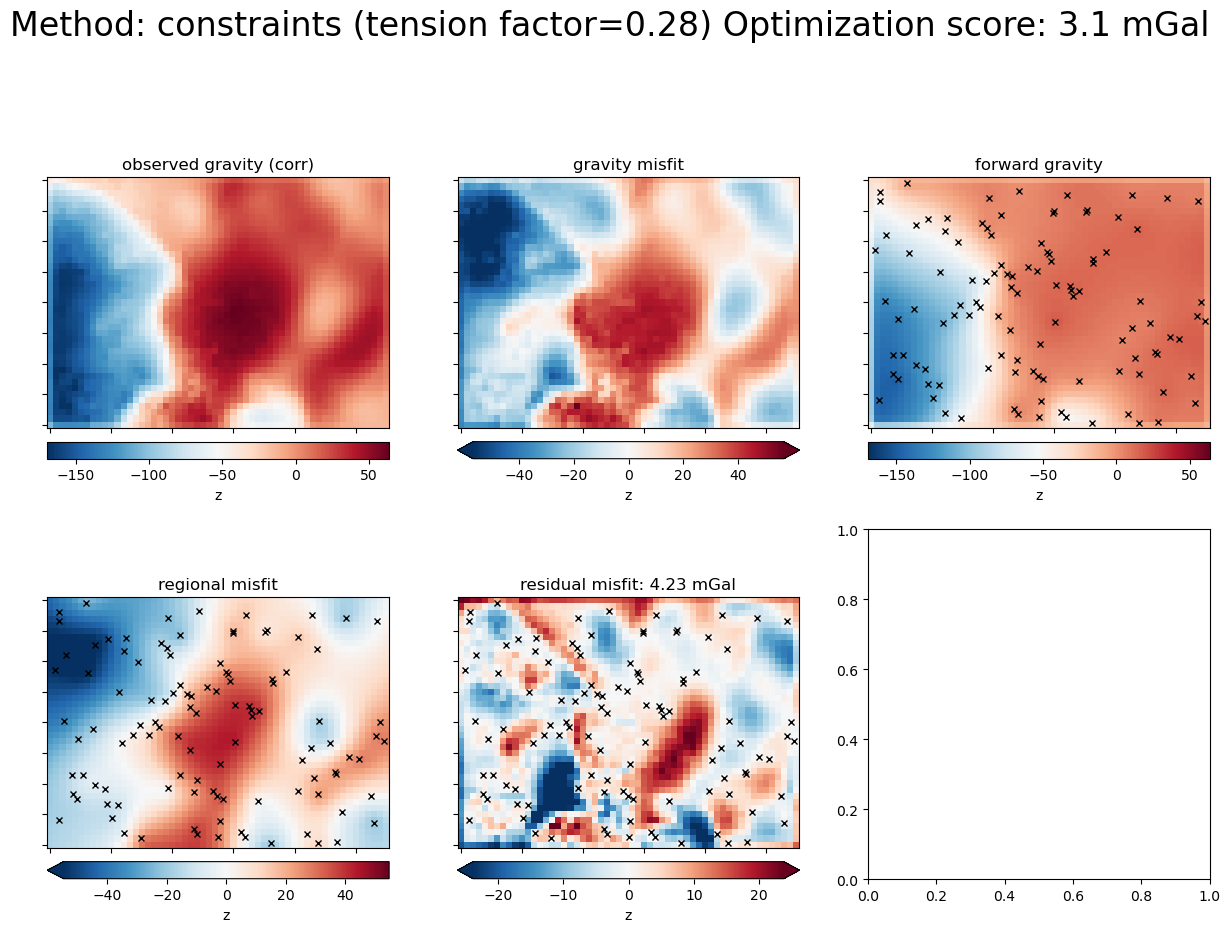

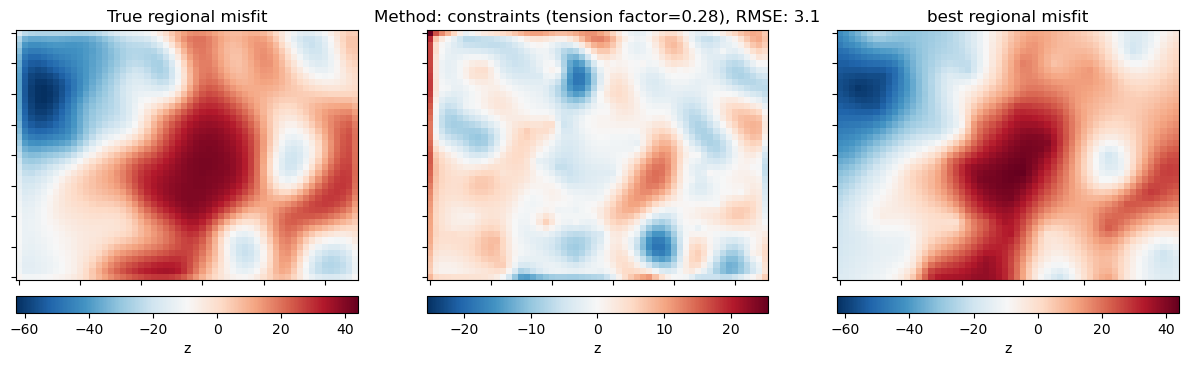

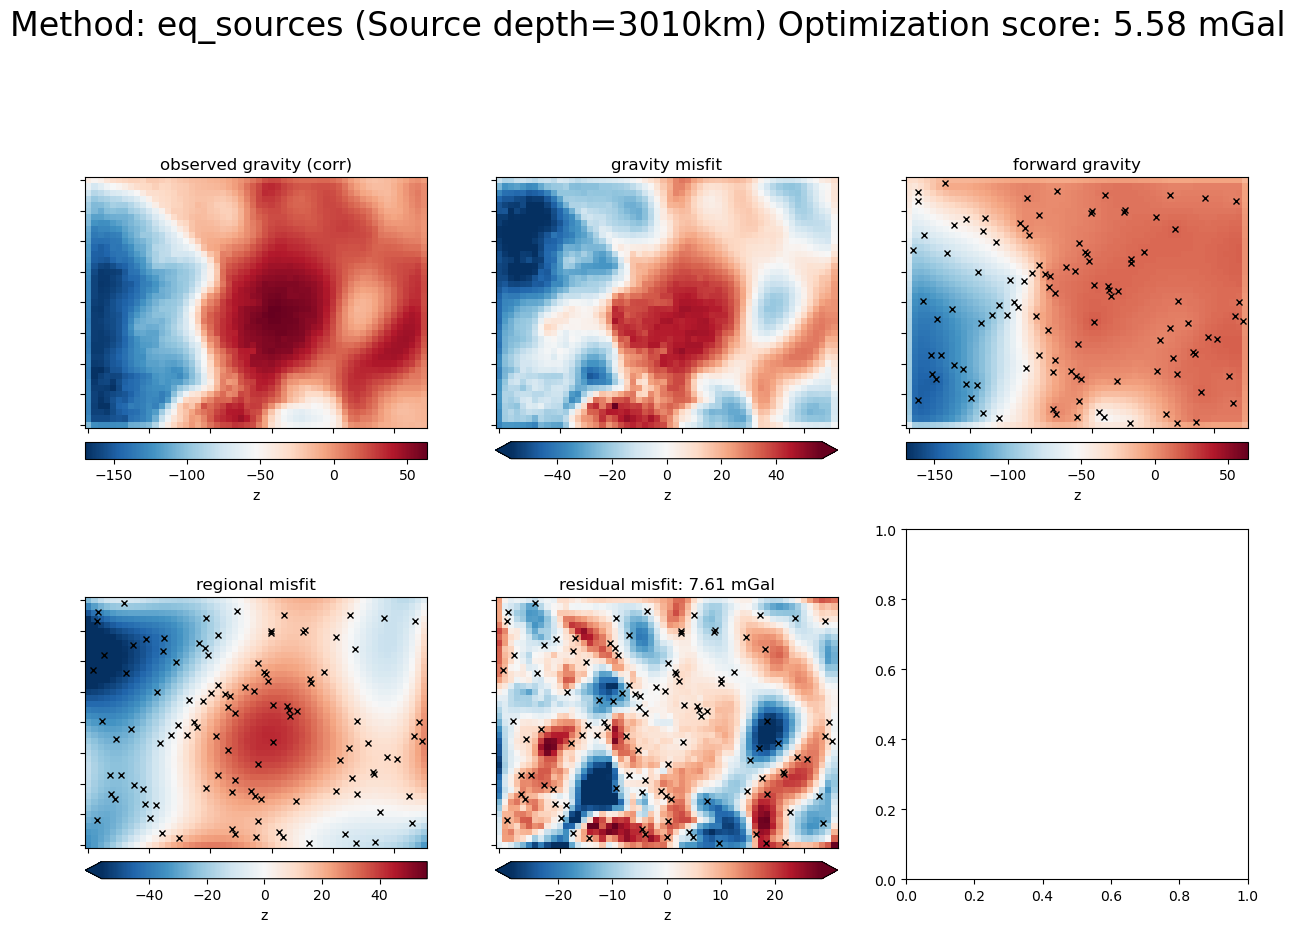

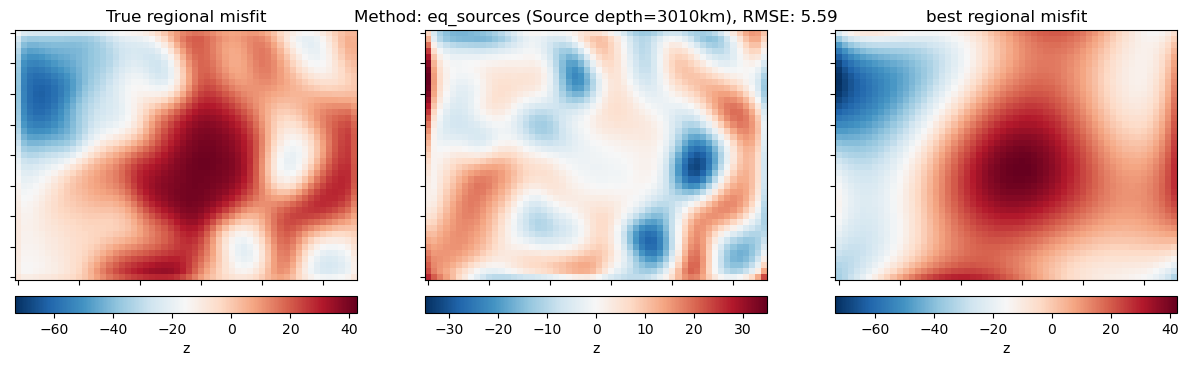

In [11]:
# load studies
study_dfs = []
for i in methods:
    study_name = f"Ross_Sea_regional_seperation_indiv_{i}_{comparison_method}"
    storage = JournalStorage(JournalFileStorage(f"../optimization_logs/{study_name}.log"))
    study = optuna.load_study(storage=storage, study_name=study_name)
    study_df = study.trials_dataframe()
    study_dfs.append(study_df) 
    
    # plot results
    plots.plot_best_param(
        study_df, 
        comparison_method, 
        regional_method=i, 
        **regional_kwargs)
    optuna.visualization.plot_slice(study).show()
    
studies = dict(zip(methods, study_dfs))

for k, v in studies.items():
    v['params_method']=k

regional_sep_combined_studies = pd.concat(studies.values(), ignore_index=True).sort_values(by="value")

In [14]:
df = regional_sep_combined_studies
df.head()

number     value             datetime_start          datetime_complete  \
117      17  3.095578 2023-03-01 16:20:50.996109 2023-03-01 16:21:17.982372   
136      36  3.100487 2023-03-01 16:20:50.879948 2023-03-01 16:21:46.387330   
118      18  3.100747 2023-03-01 16:20:50.995675 2023-03-01 16:21:19.414890   
142      42  3.100747 2023-03-01 16:20:50.901182 2023-03-01 16:21:54.237216   
119      19  3.100747 2023-03-01 16:20:50.995998 2023-03-01 16:21:20.670241   

                  duration  params_filter     state params_method  \
117 0 days 00:00:26.986263            NaN  COMPLETE   constraints   
136 0 days 00:00:55.507382            NaN  COMPLETE   constraints   
118 0 days 00:00:28.419215            NaN  COMPLETE   constraints   
142 0 days 00:01:03.336034            NaN  COMPLETE   constraints   
119 0 days 00:00:29.674243            NaN  COMPLETE   constraints   

     params_trend  params_constraints  params_eq_sources  
117           NaN                0.28                NaN  
136           NaN                0.29                NaN  
118           NaN                0.27                NaN  
142           NaN                0.27                NaN  
119           NaN                0.27                NaN

In [15]:
best_filter = df[df.params_method == 'filter'].iloc[0].number
best_trend = df[df.params_method == 'trend'].iloc[0].number
best_constraints = df[df.params_method == 'constraints'].iloc[0].number
best_eq_sources = df[df.params_method == 'eq_sources'].iloc[0].number

print(f"best trial w/ method = filter: index {best_filter}")
print(f"best trial w/ method = trend: index {best_trend}")
print(f"best trial w/ method = constraints: index {best_constraints}")
print(f"best trial w/ method = eq. sources: index {best_eq_sources}")

best trial w/ method = filter: index 23
best trial w/ method = trend: index 24
best trial w/ method = constraints: index 17
best trial w/ method = eq. sources: index 3


## Best regional seperation

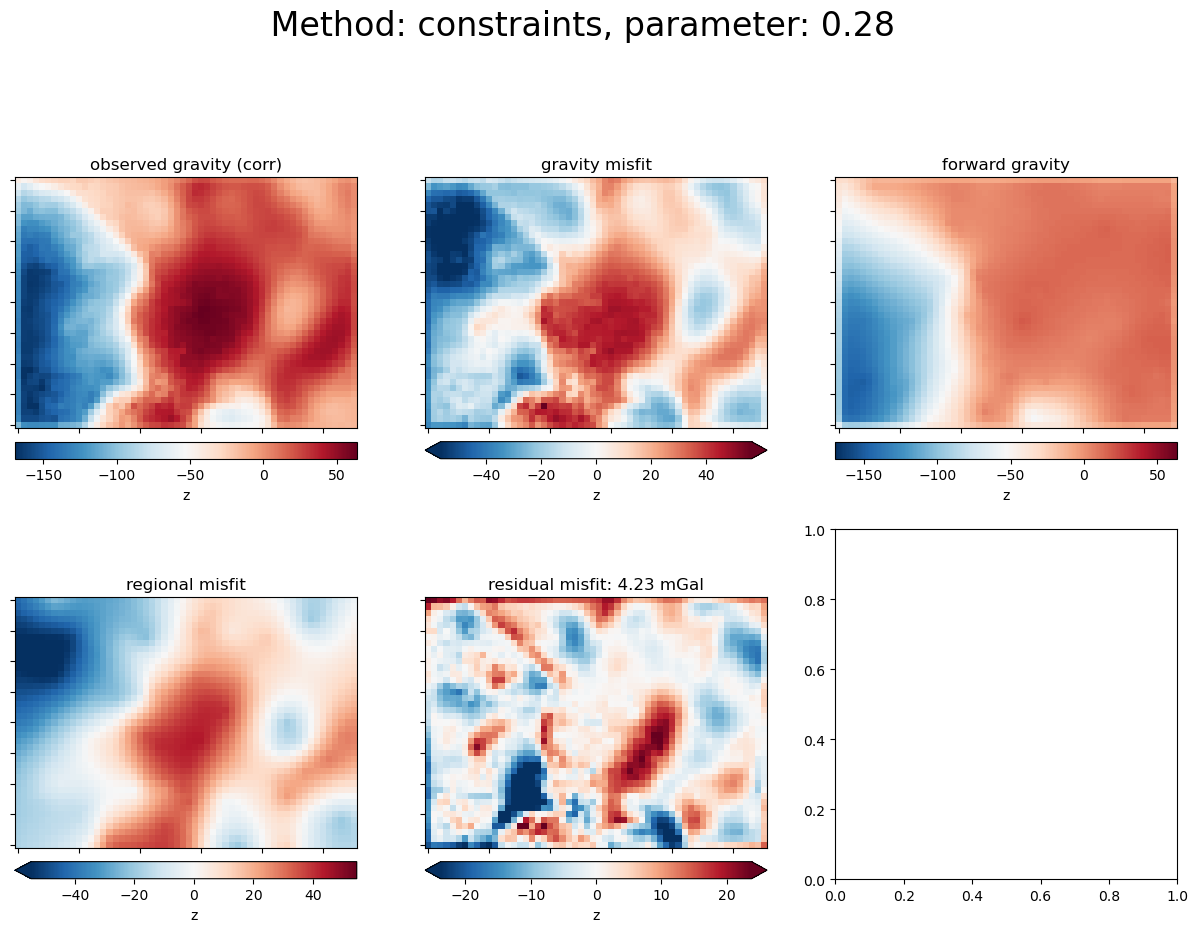

In [16]:
# choose the regional method:
# regional_method = "filter"
# regional_method = "trend"
# regional_method = "constraints"
# regional_method = "eq_sources"
regional_method = df.params_method.iloc[0]

# set the parameter:
# contraints: 1 results in pedastals, 0 is good,
# param = 1000e3

# or use the best parameter from the optimization
param = df[df[f"params_{regional_method}"].notnull()].iloc[0][f"params_{regional_method}"]

df_anomalies = inv.regional_seperation(
        input_grav=full_res_grav,
        input_forward_column = 'bed_forward',
        input_grav_column = 'Gobs_corr',
        grav_spacing=full_res_grav_spacing,
        regional_method=regional_method,
        inversion_region=inversion_region,
        filter=f"g{param}",
        trend=param,
        fill_method="pygmt",
        constraints=constraint_points,
        tension_factor=param,
        eq_sources=param,
        depth_type="relative",
        eq_damping=None,
        block_size=full_res_grav_spacing*10,
    )

anom_grids = plots.anomalies_plotting(
        df_anomalies,
        region=inversion_region,
        grav_spacing=full_res_grav_spacing,
        title=f" Method: {regional_method}, parameter: {param}",
        # constraints=constraint_points,
        input_forward_column = 'bed_forward',
        input_grav_column = 'Gobs_corr',
    )

# Plot Inputs

In [27]:
# grid the residual misfit
residual = pygmt.surface(
        data=df_anomalies[["x", "y", "res"]],
        region=inversion_region,
        spacing=full_res_grav_spacing,
        T=0.25,
        # M="0c",
        registration=registration,
    )

returning original grid


grd2cpt [ERROR]: Making a continuous cpt from a discrete cpt may give unexpected results!


returning original grid


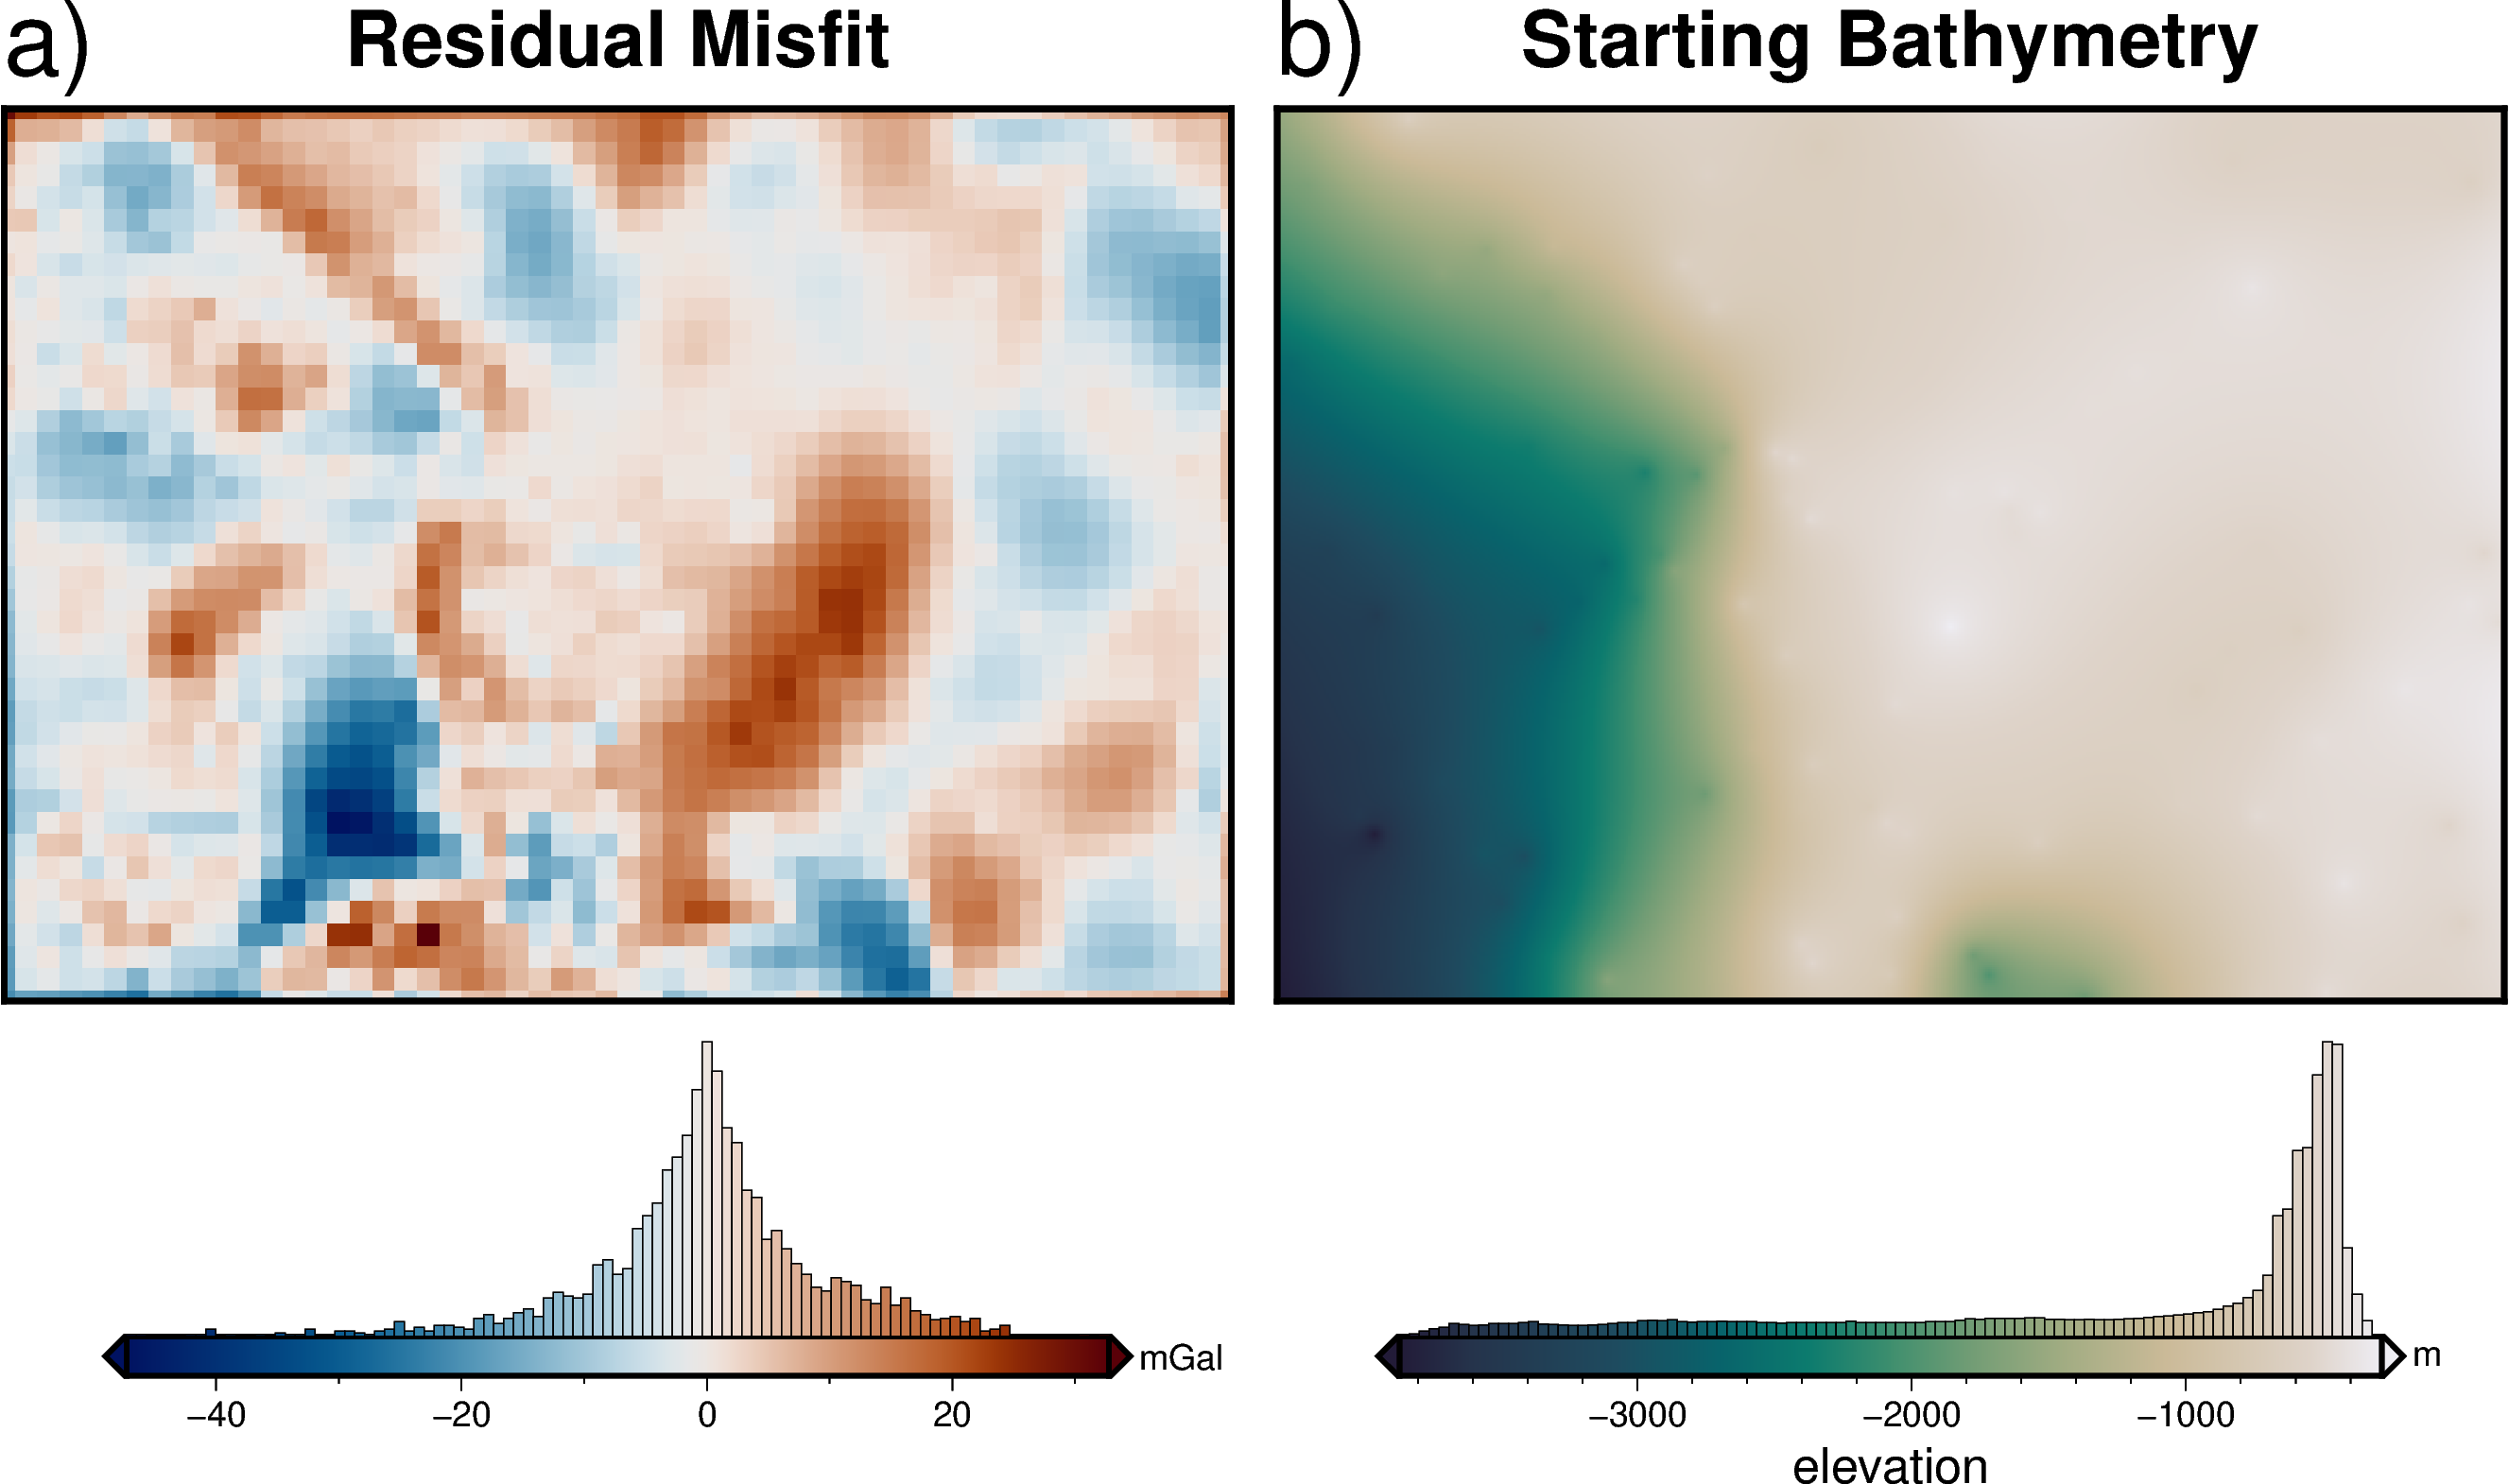

In [28]:
# plot residual misfit
fig = maps.plot_grd(
    grid=residual,
    fig_height=8,
    cmap="vik+h0",
    region=buffer_region,
    title="Residual Misfit",
    cbar_unit="mGal",
    show_region=inversion_region,
    hist=True,
    cbar_yoffset=3,
)
fig.text(
    position='TL',
    justify='BL',
    text = "a)",
    font = '26p,Helvetica,black',
    offset = 'j0/.3',
    no_clip=True,
)

# plot layer 2
fig = maps.plot_grd(
    grid=lowres_bed,
    fig_height=8,
    cmap="rain",
    reverse_cpt=True,
    region=buffer_region,
    grd2cpt=True,
    title="Starting Bathymetry",
    cbar_label="elevation",
    cbar_unit="m",
    show_region=inversion_region,
    hist=True,
    cbar_yoffset=3,
    fig=fig,
    origin_shift="xshift",
)
fig.text(
    position='TL',
    justify='BL',
    text = "b)",
    font = '26p,Helvetica,black',
    offset = 'j0/.3',
    no_clip=True,
)

fig.show()

# Inversion

Now that we have $G_{misfit}$, we can run an inversion to attempt to recover the true Layer 2 topography. 

To determine optimal inversion parameters, we will run an optimization routine which minimizes the root median square error (RMSE) of the ending Surface 2 to the true Surface 2. 

The parameters we will test are:
* Jacobian methods (annulus vs small prisms)
* Solver methods (Scipy lsqr vs Verde lsqr)
* Solver damping
* max prism change per iteration

In [ ]:
prism_results, grav_results, params, elapsed_time = inv.geo_inversion(
    input_grav=df_anomalies,
    input_grav_column = 'Gobs_corr',
    prism_layer=bed_prisms,

    max_iterations=3,
    
    # optional
    l2_norm_tolerance=.2,
    delta_l2_norm_tolerance=.8, #1.001,
    
    # Jacobian options
    deriv_type = "annulus", 
    # deriv_type = "prisms", 
    # jacobian_prism_size = 1, # doesn't seem to make a difference

    # Solver options
    # Damping: scipy least squares and verde least squares
    # Weighting: verde least squares
    # solver_type = "verde least squares",
    # solver_damping = 1e4,

    solver_type = "scipy least squares",
    solver_damping = .01,
)

In [ ]:
# grids = plots.plot_inversion_results(
#     grav_results,
#     prism_results, 
#     params,
#     grav_region=inversion_region,
#     grav_spacing=full_res_grav_spacing,
#     constraints=constraint_points,
#     plot_topo_results=False,
#     plot_grav_results=False,
#     iters_to_plot=4,
#     )

## Optimization

In [25]:
# set kwargs for inversion
no_noise_kwargs = dict(
    input_grav = df_anomalies,
    input_grav_column = 'Gobs_corr',
    prism_layer=bed_prisms,
    max_iterations = 50,
    l2_norm_tolerance = .2,
    delta_l2_norm_tolerance = .8,
)

In [17]:
# set name and storage for the optimization
study_name = "Ross_Sea_inversion_with_regional_params"
storage = JournalStorage(JournalFileStorage(f"../optimization_logs/{study_name}.log"))

# set number of runs
n_trials=100

# set objectives
objectives = [
    "RMSE"
    # "duration"
    # "constraints"
]

# set directions
directions=[
    "minimize"
    # "minimize" 
    # "minimize"
]

# # create study
# study = optuna.create_study(
#     study_name=study_name,
#     storage=storage,
#     directions=directions,
#     # sampler=optuna.samplers.TPESampler(n_startup_trials=int(n_trials/3)),
#     sampler=optuna.integration.BoTorchSampler(n_startup_trials=int(n_trials/3)),
#     load_if_exists=True,
#     )

# # define the objective function
# objective_func = opti.optimal_inversion_params(
#     lowres_bed,
#     verde_damping_limits = [0, 1e4],
#     scipy_damping_limits = [0, 1],
#     objectives = objectives,
#     constraints = constraint_points,
#     **no_noise_kwargs)

# # run the optimization
# with inv_utils.HiddenPrints():
#     study, study_df = opti.optuna_parallel(
#         study_name=study_name,
#         study_storage=storage,
#         objective = objective_func,
#         n_trials=n_trials,
#         maximize_cpus=True,
#     )

/tmp/ipykernel_2901138/2148694132.py:3: ExperimentalWarning:

JournalStorage is experimental (supported from v3.1.0). The interface can change in the future.



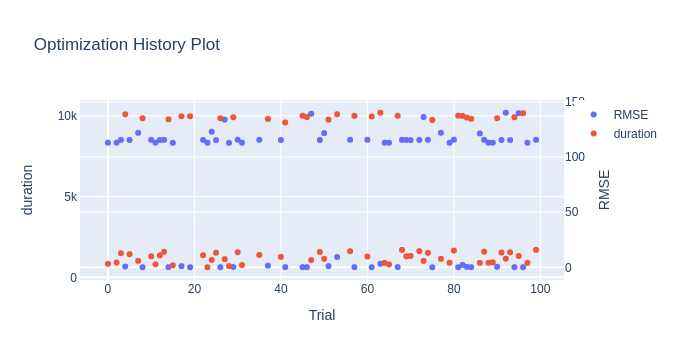

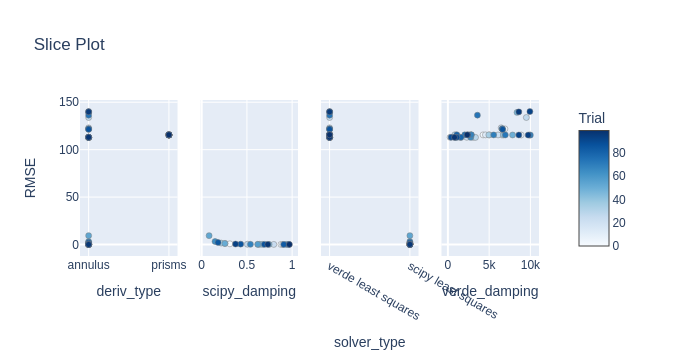

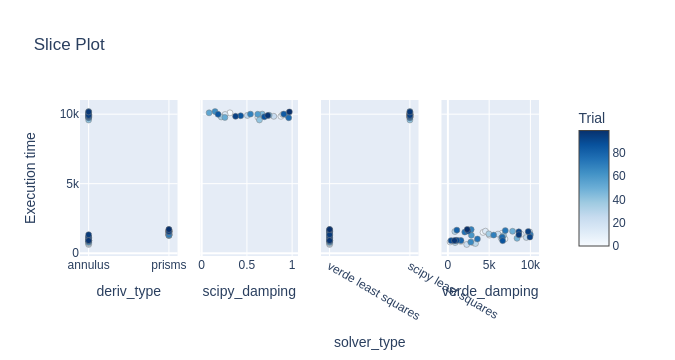

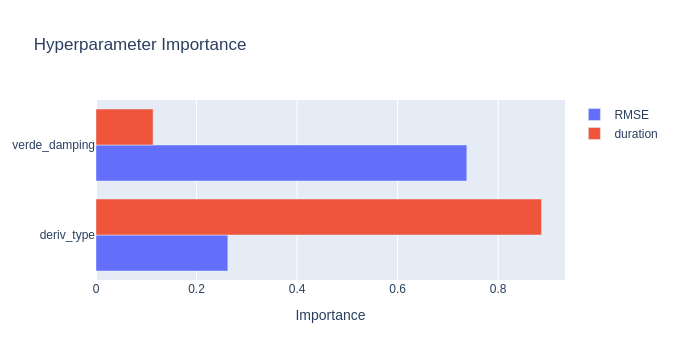

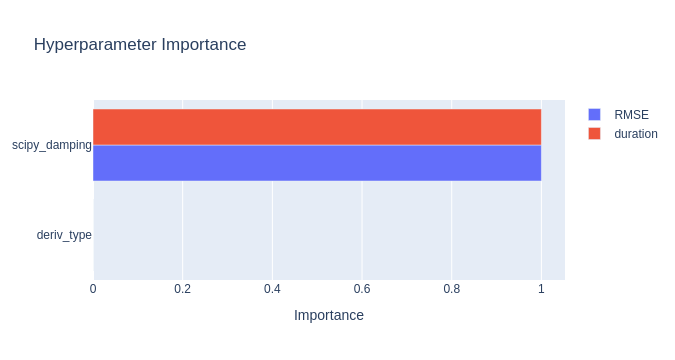

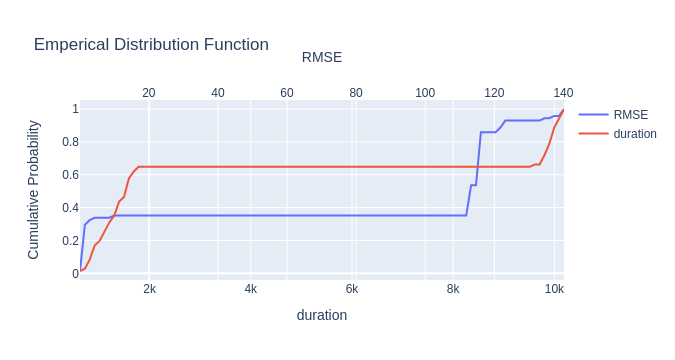

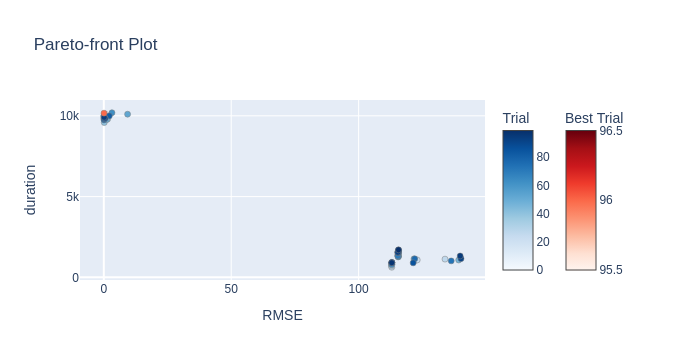

In [19]:
# load and plot past study
study = optuna.load_study(
        study_name=study_name,
        storage=storage,
        )

plots.plot_optuna_inversion_figures(
    study, 
    target_names=objectives,
    include_duration=True,
)

In [20]:
start = study.trials_dataframe().sort_values(by="datetime_start").iloc[0].datetime_start
stop = study.trials_dataframe().sort_values(by="datetime_complete", ascending=False).iloc[0].datetime_complete

time = stop - start
print(f"Total time for optimizaiton: {time.total_seconds()/60} minutes")

Total time for optimizaiton: 169.8828816666667 minutes


In [21]:
df, best_verde, best_scipy, best_prisms, best_annulus = opti.get_best_of_each_param(study, objectives)
# df.sort_values(by=["RMSE", "constraints", "duration"], inplace=True)
df

best trial w/ solver = verde: index 28
best trial w/ solver = scipy: index 96
best trial w/ deriv = prisms: index 70
best trial w/ deriv = annulus: index 96


number     value             datetime_start          datetime_complete  \
96      96  0.077617 2023-03-01 16:30:49.446906 2023-03-01 19:20:13.734254   
75      75  0.078869 2023-03-01 16:30:52.698558 2023-03-01 19:13:15.416857   
61      61  0.083082 2023-03-01 16:30:52.273792 2023-03-01 19:16:51.655530   
81      81  0.088565 2023-03-01 16:30:52.653066 2023-03-01 19:17:42.594363   
19      19  0.090989 2023-03-01 16:30:57.347137 2023-03-01 19:17:11.538734   
..     ...       ...                        ...                        ...   
71      71       NaN 2023-03-01 16:30:54.606464                        NaT   
76      76       NaN 2023-03-01 16:30:54.981424                        NaT   
78      78       NaN 2023-03-01 16:30:53.516880                        NaT   
85      85       NaN 2023-03-01 16:30:48.082435                        NaT   
98      98       NaN 2023-03-01 16:30:47.714186                        NaT   

                 duration params_deriv_type  params_scipy_damping  \
96 0 days 02:49:24.287348           annulus              0.969883   
75 0 days 02:42:22.718299           annulus              0.962145   
61 0 days 02:45:59.381738           annulus              0.937416   
81 0 days 02:46:49.941297           annulus              0.907896   
19 0 days 02:46:14.191597           annulus              0.895706   
..                    ...               ...                   ...   
71                    NaT            prisms              0.939994   
76                    NaT            prisms              0.412615   
78                    NaT            prisms              0.647781   
85                    NaT            prisms              0.031708   
98                    NaT            prisms              0.874362   

     params_solver_type  params_verde_damping     state  
96  scipy least squares                   NaN  COMPLETE  
75  scipy least squares                   NaN  COMPLETE  
61  scipy least squares                   NaN  COMPLETE  
81  scipy least squares                   NaN  COMPLETE  
19  scipy least squares                   NaN  COMPLETE  
..                  ...                   ...       ...  
71  scipy least squares                   NaN   RUNNING  
76  scipy least squares                   NaN   RUNNING  
78  scipy least squares                   NaN   RUNNING  
85  scipy least squares                   NaN   RUNNING  
98  scipy least squares                   NaN   RUNNING  

[100 rows x 10 columns]

{'deriv_type': 'annulus', 'solver_type': 'scipy least squares', 'scipy_damping': 0.9698829890961718}
grid spacings don't match, using smaller spacing (1000.0m).
Warning, requested spacing (1000.0) is smaller than the original  (5000.0).
returning original grid
RMSE between surfaces at constraints: 6.9 m


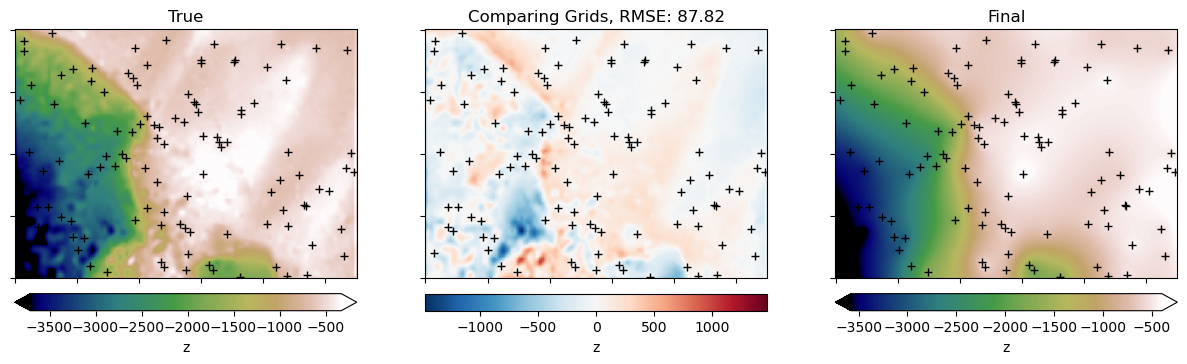

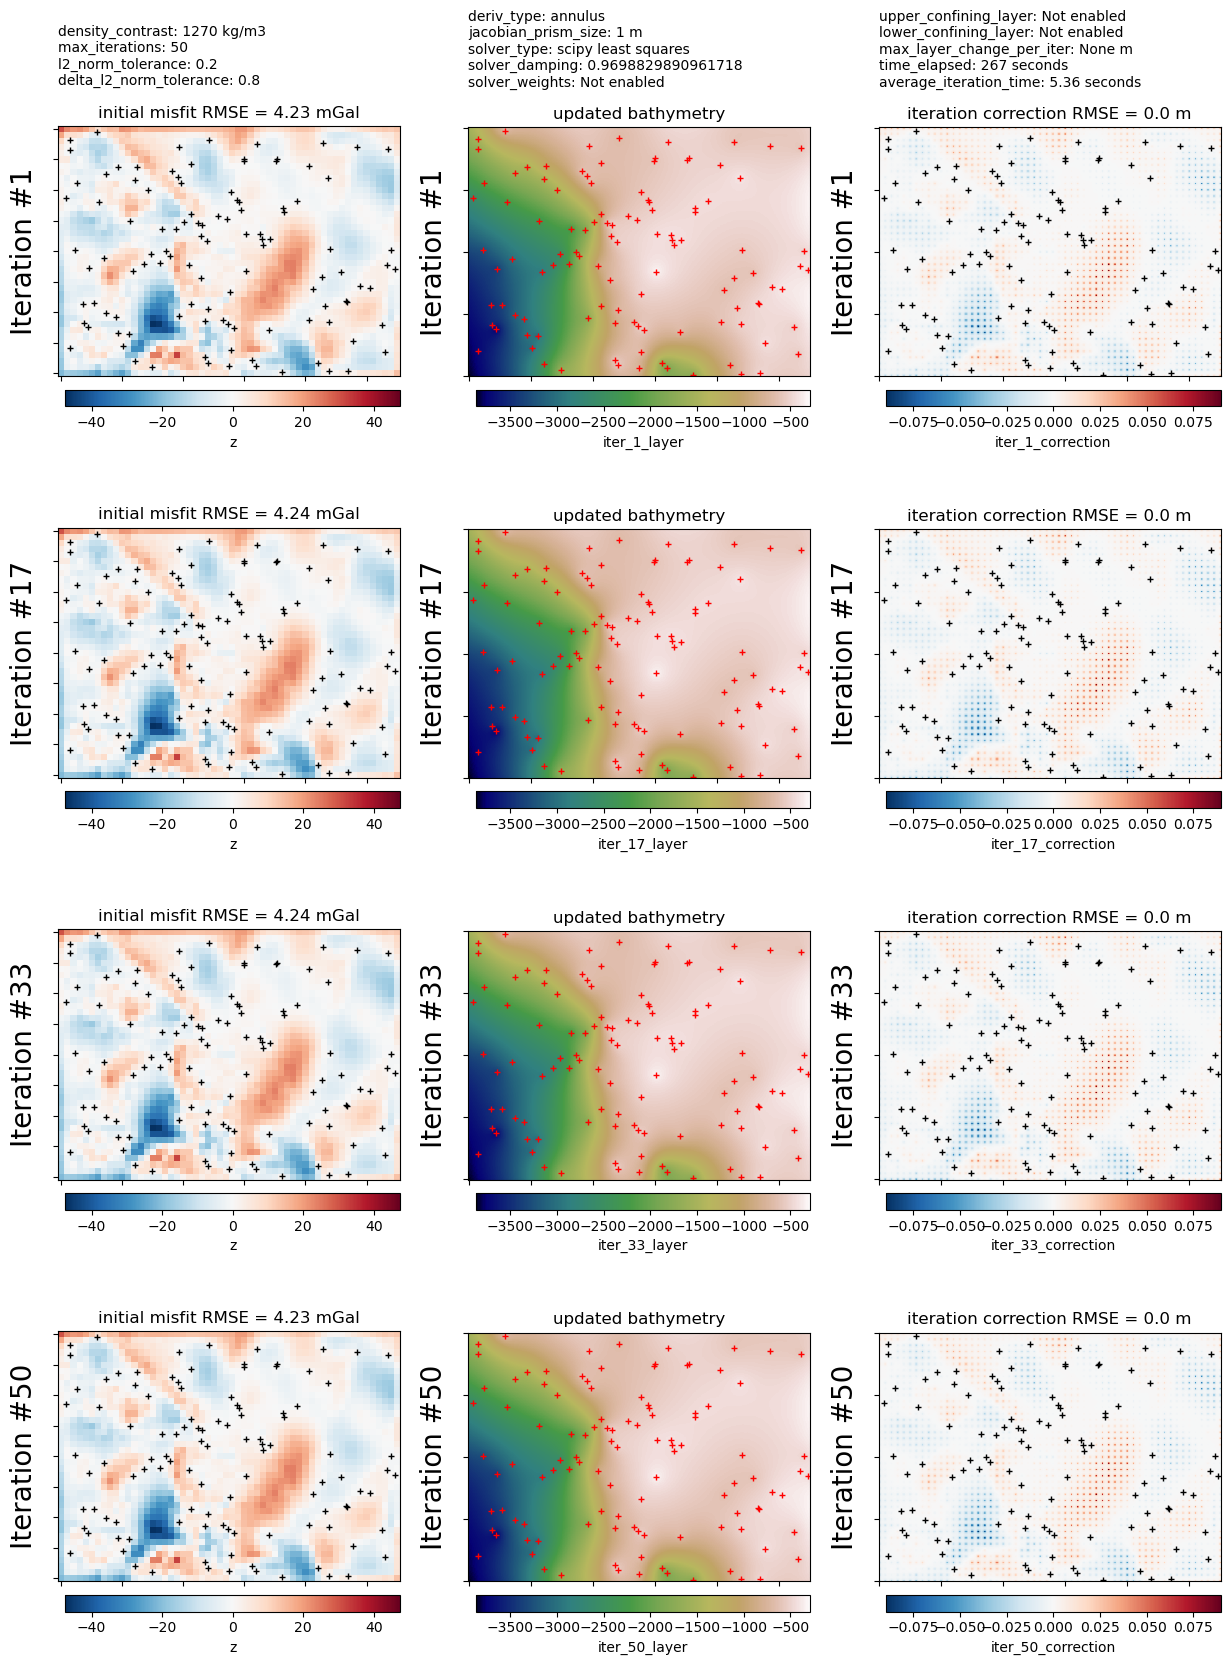

In [26]:
ind = [trial.number for trial in study.trials].index(best_annulus)
best_params = study.trials[ind].params
print(best_params)

plots.plot_best_inversion(
    bed,
    buffer_region,
    best_params=best_params,
    grav_spacing=full_res_grav_spacing,
    constraint_points = constraint_points,
    **no_noise_kwargs
)

In [ ]:
ind = [trial.number for trial in study.trials].index(best_annulus)
best_params = study.trials[ind].params
print(best_params)

plots.plot_best_inversion(
    true_layer2,
    buffer_region,
    best_params=best_params,
    grav_spacing=grav_spacing,
    constraint_points = constraint_points,
    **no_noise_kwargs
)

In [ ]:
ind = [trial.number for trial in study.trials].index(best_verde)
best_params = study.trials[ind].params
print(best_params)

plots.plot_best_inversion(
    true_layer2,
    buffer_region,
    best_params=best_params,
    grav_spacing=grav_spacing,
    constraint_points = constraint_points,
    **no_noise_kwargs
)

# Repeat with simple noise

The above inversion was able to fully recover Layer 2. This is expected, since there was no noise in the data, and we used a very simple 2 layer model to create the observed gravity. Next we add 2% gaussian noise to $G_{misfit}$ to see how the inversion performs.

In [ ]:
df_anomalies_noise = df_anomalies.copy()

df_anomalies_noise['res'] = synth.contaminate(
    df_anomalies_noise.res,
    stddev=0.02,
    percent=True,
    seed=0,
)
df_anomalies_noise

In [ ]:
# set kwargs for inversion
noise_kwargs = dict(
    input_grav = df_anomalies_noise,
    input_grav_column = 'Gobs_corr',
    prism_layer=layer2_prisms,
    max_iterations = 50,
    l2_norm_tolerance = .2,
    delta_l2_norm_tolerance = 0.8,#1.02,
)

In [ ]:
# set name and storage for the optimization
study_name = "2layer_inversion_with_regional_noise_params"
storage = JournalStorage(JournalFileStorage(f"../optimization_logs/{study_name}.log"))

# set number of runs
n_trials=100

# set objectives
objectives = [
    "RMSE"
    # "duration"
    # "constraints"
]

# set directions
directions=[
    "minimize"
    # "minimize" 
    # "minimize"
]

# # create study
# study = optuna.create_study(
#     study_name=study_name,
#     storage=storage,
#     directions=directions,
#     # sampler=optuna.samplers.TPESampler(n_startup_trials=int(n_trials/3)),
#     sampler=optuna.integration.BoTorchSampler(n_startup_trials=int(n_trials/3)),
#     load_if_exists=True,
#     )

# # define the objective function
# objective_func = opti.optimal_inversion_params(
#     true_layer2,
#     verde_damping_limits = [0, 1e4],
#     scipy_damping_limits = [0, 1],
#     objectives = objectives,
#     constraints = constraint_points,
#     **noise_kwargs)

# # run the optimization
# with inv_utils.HiddenPrints():
#     study, study_df = opti.optuna_parallel(
#         study_name=study_name,
#         study_storage=storage,
#         objective = objective_func,
#         n_trials=n_trials,
#         maximize_cpus=True,
#     )

In [ ]:
# load and plot past study
study = optuna.load_study(
        study_name=study_name,
        storage=storage,
        )

plots.plot_optuna_inversion_figures(
    study, 
    target_names=objectives,
    # include_duration=True,
)

In [ ]:
start = study.trials_dataframe().sort_values(by="datetime_start").iloc[0].datetime_start
stop = study.trials_dataframe().sort_values(by="datetime_complete", ascending=False).iloc[0].datetime_complete

time = stop - start
print(f"Total time for optimizaiton: {time.total_seconds()/60} minutes")

In [ ]:
df, best_verde, best_scipy, best_prisms, best_annulus = opti.get_best_of_each_param(study, objectives)
# df.sort_values(by=["RMSE", "constraints", "duration"], inplace=True)
df

In [ ]:
ind = [trial.number for trial in study.trials].index(best_scipy)
best_params = study.trials[ind].params
print(best_params)

plots.plot_best_inversion(
    true_layer2,
    buffer_region,
    best_params=best_params,
    grav_spacing=grav_spacing,
    constraint_points = constraint_points,
    **noise_kwargs
)

In [ ]:
ind = [trial.number for trial in study.trials].index(best_scipy)
best_params = study.trials[ind].params
print(best_params)

plots.plot_best_inversion(
    true_layer2,
    buffer_region,
    best_params=best_params,
    grav_spacing=grav_spacing,
    constraint_points = constraint_points,
    **noise_kwargs
)

# Repeat with synthetic survey

In [ ]:
grav_survey = pd.read_csv(
    "../synthetic_data/synthetic_gravity_simple.csv.gz",
    sep=",",
    header="infer",
    index_col=None,
    compression="gzip",
)
grav_spacing_survey = 2e3
grav_survey

In [ ]:
# set standard column names
grav_survey = grav_survey.rename(columns={
    'free_air_anomaly':'Gobs',
    'ellipsoidal_elevation':'z',
})

# remove other columns
grav_survey = grav_survey[["x", "y", "Gobs", "z"]]

# center gravity around 0
grav_survey.Gobs -= grav_survey.Gobs.median()

print(f"gravity: {len(grav_survey)} points")
print(f"gravity avg. elevation: {int(np.nanmean(grav_survey.z))}")

# grid the observed gravity
Gobs = grav_survey.set_index(["y", "x"]).to_xarray().Gobs

grav_survey

## Bouguer correction
### Ice prisms

In [ ]:
# create prisms around Layer 1
# positive densities above reference, negative below
layer1_prisms = inv_utils.grids_to_prisms(
    top=layer1,
    bottom=layer1.values.mean(),
    density=xr.where(layer1>=layer1.values.mean(), 917, -917),
)

# plots.show_prism_layers(
#     [layer1_prisms],
#     cmap="viridis",
#     color_by="density",
#     # color_by="thickness",
#     zscale=100,
#     clip_box=False,
#     log_scale=False,
# )

### Ice gravity

In [ ]:
# calculate gravity of layer1
layer1_grid, layer1_df = inv_utils.forward_grav_of_prismlayer(
    [layer1_prisms],
    grav_survey,
    names=['layer1_prisms'],
    remove_median=True,
    progressbar=True,
    plot=False,
)

grav_survey['layer1_forward'] = layer1_df.forward_total

# subtract from observed gravity
grav_survey['Gobs_corr']=grav_survey.Gobs - grav_survey.layer1_forward

# center on 0
grav_survey['Gobs_corr'] -= grav_survey['Gobs_corr'].median()

# grid the results
layer1_forward = grav_survey.set_index(["y", "x"]).to_xarray().layer1_forward
Gobs_corr = grav_survey.set_index(["y", "x"]).to_xarray().Gobs_corr

# center on 0
layer1_forward -= np.median(layer1_forward)
Gobs_corr -= np.median(Gobs_corr.values)
grav_survey

In [ ]:
# plot Layer 1 gravity
fig = maps.plot_grd(
    grid=layer1_forward,
    fig_height=8,
    cmap="vik+h0",
    region=buffer_region,
    title='Surface 1 forward gravity',
    cbar_unit="mGal",
    show_region=inversion_region,
    hist=True,
    cbar_yoffset=3,
)
fig.text(
    position='TL',
    justify='BL',
    text = "a)",
    font = '26p,Helvetica,black',
    offset = 'j0/.3',
    no_clip=True,
)
# plot corrected gravity
fig = maps.plot_grd(
    grid=Gobs_corr,
    fig_height=8,
    cmap="vik+h0",
    region=buffer_region,
    title="Corrected gravity",
    cbar_unit="mGal",
    show_region=inversion_region,
    hist=True,
    cbar_yoffset=3,
    fig=fig,
    origin_shift="xshift",
)
fig.text(
    position='TL',
    justify='BL',
    text = "b)",
    font = '26p,Helvetica,black',
    offset = 'j0/.3',
    no_clip=True,
)
fig.show()

## Gravity misfit
### Bed prisms

In [ ]:
# create prisms around Layer 2
# positive densities above reference, negative below
layer2_prisms = inv_utils.grids_to_prisms(
    top=starting_layer2,
    bottom=starting_layer2.values.mean(),
    density=xr.where(starting_layer2>=starting_layer2.values.mean(), 2300-917, -(2300-917)),
)

# plots.show_prism_layers(
#     [layer2_prisms],
#     cmap="viridis",
#     color_by="density",
#     # color_by="thickness",
#     zscale=100,
#     clip_box=False,
#     log_scale=False,
# )

### Bed gravity

In [ ]:
# calculate gravity of layer1
layer2_forward, layer2_df = inv_utils.forward_grav_of_prismlayer(
    [layer2_prisms],
    grav_survey,
    names=['layer2_prisms'],
    remove_median=True,
    progressbar=True,
    plot=False,
)
layer2_forward = layer2_forward.forward_total

grav_survey['layer2_forward'] = layer2_df.forward_total
grav_survey

In [ ]:
# plot layer 2 gravity
fig = maps.plot_grd(
    grid=layer2_forward,
    fig_height=8,
    cmap="vik+h0",
    region=buffer_region,
    title="Surface 2 forward gravity",
    cbar_unit="mGal",
    show_region=inversion_region,
    hist=True,
    cbar_yoffset=3,
)
fig.text(
    position='TL',
    justify='BL',
    text = "a)",
    font = '26p,Helvetica,black',
    offset = 'j0/.3',
    no_clip=True,
)
# plot layer 2 topography
fig = maps.plot_grd(
    grid=starting_layer2,
    fig_height=8,
    cmap="rain",
    reverse_cpt=True,
    region=buffer_region,
    grd2cpt=True,
    title="Surface 2",
    cbar_label="elevation",
    cbar_unit="m",
    show_region=inversion_region,
    hist=True,
    cbar_yoffset=3,
    fig=fig,
    origin_shift="xshift",
    points=constraint_points,
    points_style="c0.1c",
)
fig.text(
    position='TL',
    justify='BL',
    text = "b)",
    font = '26p,Helvetica,black',
    offset = 'j0/.3',
    no_clip=True,
)
fig.show()

## Regional - Residual seperation

In [ ]:
# load resolution gravity grid
synthetic_gravity = xr.open_zarr("../synthetic_data/synthetic_forward_grav_simple_with_regional.zarr")

# load the true regional gravity anomaly
true_layer3_grav_survey = fetch.resample_grid(
    synthetic_gravity.Layer3,
    region=inversion_region,
    spacing=1e3, # full resolution spacing
    registration=registration,
)

In [ ]:
regional_survey_kwargs = dict(
    input_grav=grav_survey,
    input_forward_column = 'layer2_forward',
    input_grav_column = 'Gobs_corr',
    grav_spacing=grav_spacing,
    inversion_region=inversion_region,
    true_regional=true_layer3_grav,
    constraints=constraint_points,
)

In [ ]:
# set comparison method
# comparison_method='minimize_constraints'
comparison_method='regional_comparison'

methods = [
    "filter", 
    "trend", 
    "constraints", 
    "eq_sources"
    ]

# for i in methods:
#     # set name and storage for the optimization
#     study_name = f"regional_seperation_survey_indiv_{i}_{comparison_method}"
#     storage = JournalStorage(JournalFileStorage(f"../optimization_logs/{study_name}.log"))

#     # set number of runs
#     n_trials=50

#     # create a new study
#     study = optuna.create_study(
#         study_name=study_name,
#         storage=storage,
#         direction="minimize",
#         sampler=optuna.samplers.TPESampler(n_startup_trials=int(n_trials/3)),
#         load_if_exists=True,
#         )

#     # define the objective function
#     objective = opti.optimal_regional_params(
#         comparison_method = comparison_method,
#         regional_method = i,
#         filter_limits = [10e3, 1000e3, 10e3], # 100 options
#         trend_limits = [1, 20, 1], # 20 options
#         constraints_limits = [0, 1, 0.01], # 101 options
#         eq_sources_limits = [10e3, 10000e3, 10e3], # 1000 options
#         **regional_survey_kwargs)

#     # run the optimization
#     with inv_utils.HiddenPrints():
#         with warnings.catch_warnings():
#             warnings.simplefilter("ignore")
#             study, study_df = opti.optuna_parallel(
#                 study_name=study_name,
#                 study_storage=storage,
#                 objective=objective,
#                 n_trials=n_trials,
#                 maximize_cpus=True,
#             )

# load studies
study_dfs = []
for i in methods:
    study_name = f"regional_seperation_survey_indiv_{i}_{comparison_method}"
    storage = JournalStorage(JournalFileStorage(f"../optimization_logs/{study_name}.log"))
    study = optuna.load_study(storage=storage, study_name=study_name)
    study_df = study.trials_dataframe()
    study_dfs.append(study_df) 
    
    # plot results
    plots.plot_best_param(
        study_df, 
        comparison_method, 
        regional_method=i, 
        **regional_survey_kwargs)
    optuna.visualization.plot_slice(study).show()
    
studies = dict(zip(methods, study_dfs))

for k, v in studies.items():
    v['params_method']=k

regional_sep_combined_studies = pd.concat(studies.values(), ignore_index=True).sort_values(by="value")

In [ ]:
df = regional_sep_combined_studies
df.head()

In [ ]:
best_filter = df[df.params_method == 'filter'].iloc[0].number
best_trend = df[df.params_method == 'trend'].iloc[0].number
best_constraints = df[df.params_method == 'constraints'].iloc[0].number
best_eq_sources = df[df.params_method == 'eq_sources'].iloc[0].number

print(f"best trial w/ solver = verde: index {best_filter}")
print(f"best trial w/ solver = scipy: index {best_trend}")
print(f"best trial w/ deriv = prisms: index {best_constraints}")
print(f"best trial w/ deriv = annulus: index {best_eq_sources}")

### Best regional seperation

In [ ]:
# choose the regional method:
# regional_method = "filter"
# regional_method = "trend"
regional_method = "constraints"
# regional_method = "eq_sources"

# set the parameter:
# contraints: 1 results in pedastals, 0 is good,
# param = .25

# or use the best parameter from the optimization
param = df[df[f"params_{regional_method}"].notnull()].iloc[0][f"params_{regional_method}"]

df_anomalies_survey = inv.regional_seperation(
        input_grav=grav_survey,
        input_forward_column = 'layer2_forward',
        input_grav_column = 'Gobs_corr',
        grav_spacing=grav_spacing,
        regional_method=regional_method,
        inversion_region=inversion_region,
        filter=f"g{param}",
        trend=param,
        fill_method="pygmt",
        constraints=constraint_points,
        tension_factor=param,
        eq_sources=param,
        depth_type="relative",
        eq_damping=None,
        block_size=grav_spacing,
    )

anom_grids = plots.anomalies_plotting(
        df_anomalies_survey,
        region=inversion_region,
        grav_spacing=grav_spacing,
        title=f" Method: {regional_method}, parameter: {param}",
        # constraints=constraint_points,
        input_forward_column = 'layer2_forward',
        input_grav_column = 'Gobs_corr',
    )

## plot inputs

In [ ]:
# grid the residual misfit
residual = pygmt.surface(
        data=df_anomalies_survey[["x", "y", "res"]],
        region=inversion_region,
        spacing=grav_spacing,
        T=0.25,
        # M="0c",
        registration=registration,
    )

In [ ]:
# plot observed gravity
fig = maps.plot_grd(
    grid=residual,
    fig_height=8,
    cmap="vik+h0",
    region=buffer_region,
    title="Residual Misfit",
    cbar_unit="mGal",
    show_region=inversion_region,
    hist=True,
    cbar_yoffset=3,
)
fig.text(
    position='TL',
    justify='BL',
    text = "a)",
    font = '26p,Helvetica,black',
    offset = 'j0/.3',
    no_clip=True,
)

# plot layer 2
fig = maps.plot_grd(
    grid=starting_layer2,
    fig_height=8,
    cmap="rain",
    reverse_cpt=True,
    region=buffer_region,
    grd2cpt=True,
    title="Starting Surface 2",
    cbar_label="elevation",
    cbar_unit="m",
    show_region=inversion_region,
    hist=True,
    cbar_yoffset=3,
    fig=fig,
    origin_shift="xshift",
    points=constraint_points,
    points_style="c0.1c",
)
fig.text(
    position='TL',
    justify='BL',
    text = "b)",
    font = '26p,Helvetica,black',
    offset = 'j0/.3',
    no_clip=True,
)

fig.show()

## Inversion

In [ ]:
# set kwargs for inversion
survey_kwargs = dict(
    input_grav = df_anomalies_survey,
    input_grav_column = 'Gobs_corr',
    prism_layer=layer2_prisms,
    max_iterations = 50,
    l2_norm_tolerance = .2,
    delta_l2_norm_tolerance = .8,
)

In [ ]:
# set name and storage for the optimization
study_name = "2layer_inversion_with_regional_survey_params"
storage = JournalStorage(JournalFileStorage(f"../optimization_logs/{study_name}.log"))

# set number of runs
n_trials=100

# set objectives
objectives = [
    "RMSE"
    # "duration"
    # "constraints"
]

# set directions
directions=[
    "minimize"
    # "minimize" 
    # "minimize"
]

# create study
study = optuna.create_study(
    study_name=study_name,
    storage=storage,
    directions=directions,
    # sampler=optuna.samplers.TPESampler(n_startup_trials=int(n_trials/3)),
    sampler=optuna.integration.BoTorchSampler(n_startup_trials=int(n_trials/3)),
    load_if_exists=True,
    )

# define the objective function
objective_func = opti.optimal_inversion_params(
    true_layer2,
    verde_damping_limits = [0, 1e4],
    scipy_damping_limits = [0, 1],
    objectives = objectives,
    constraints = constraint_points,
    **survey_kwargs)

# run the optimization
with inv_utils.HiddenPrints():
    study, study_df = opti.optuna_parallel(
        study_name=study_name,
        study_storage=storage,
        objective = objective_func,
        n_trials=n_trials,
        maximize_cpus=True,
    )

In [ ]:
# load and plot past study
study = optuna.load_study(
        study_name=study_name,
        storage=storage,
        )

plots.plot_optuna_inversion_figures(
    study, 
    target_names=objectives,
    # include_duration=True,
)

In [ ]:
df, best_verde, best_scipy, best_prisms, best_annulus = opti.get_best_of_each_param(study, objectives)
# df.sort_values(by=["RMSE", "constraints", "duration"], inplace=True)
df

In [ ]:
ind = [trial.number for trial in study.trials].index(best_scipy)
best_params = study.trials[ind].params
print(best_params)

plots.plot_best_inversion(
    true_layer2,
    buffer_region,
    best_params=best_params,
    grav_spacing=grav_spacing,
    constraint_points = constraint_points,
    **noise_kwargs
)